In [1]:
# Major sources of data and tools
import osmnx as ox
import networkx as nx

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.cm as cm
import matplotlib.colors as colors

# Simplification
import pandas as pd
import numpy as np
from shapely.geometry import LineString, Point

# Store computed centrality measures
import time
import pickle

# Compute information and straightness centrality
import geopy.distance

In [2]:
plt.ioff()

# Petaluma
north, west = 38.274876, -122.680558
south, east = 38.216280, -122.584074

# load entire graph
Petaluma_G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Davis
north, south, east, west = 38.5754, 38.5156, -121.6759, -121.7941
Davis_G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

# Portales
north, west = 34.201816, -103.371467
south, east = 34.170154, -103.316182
Portales_G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

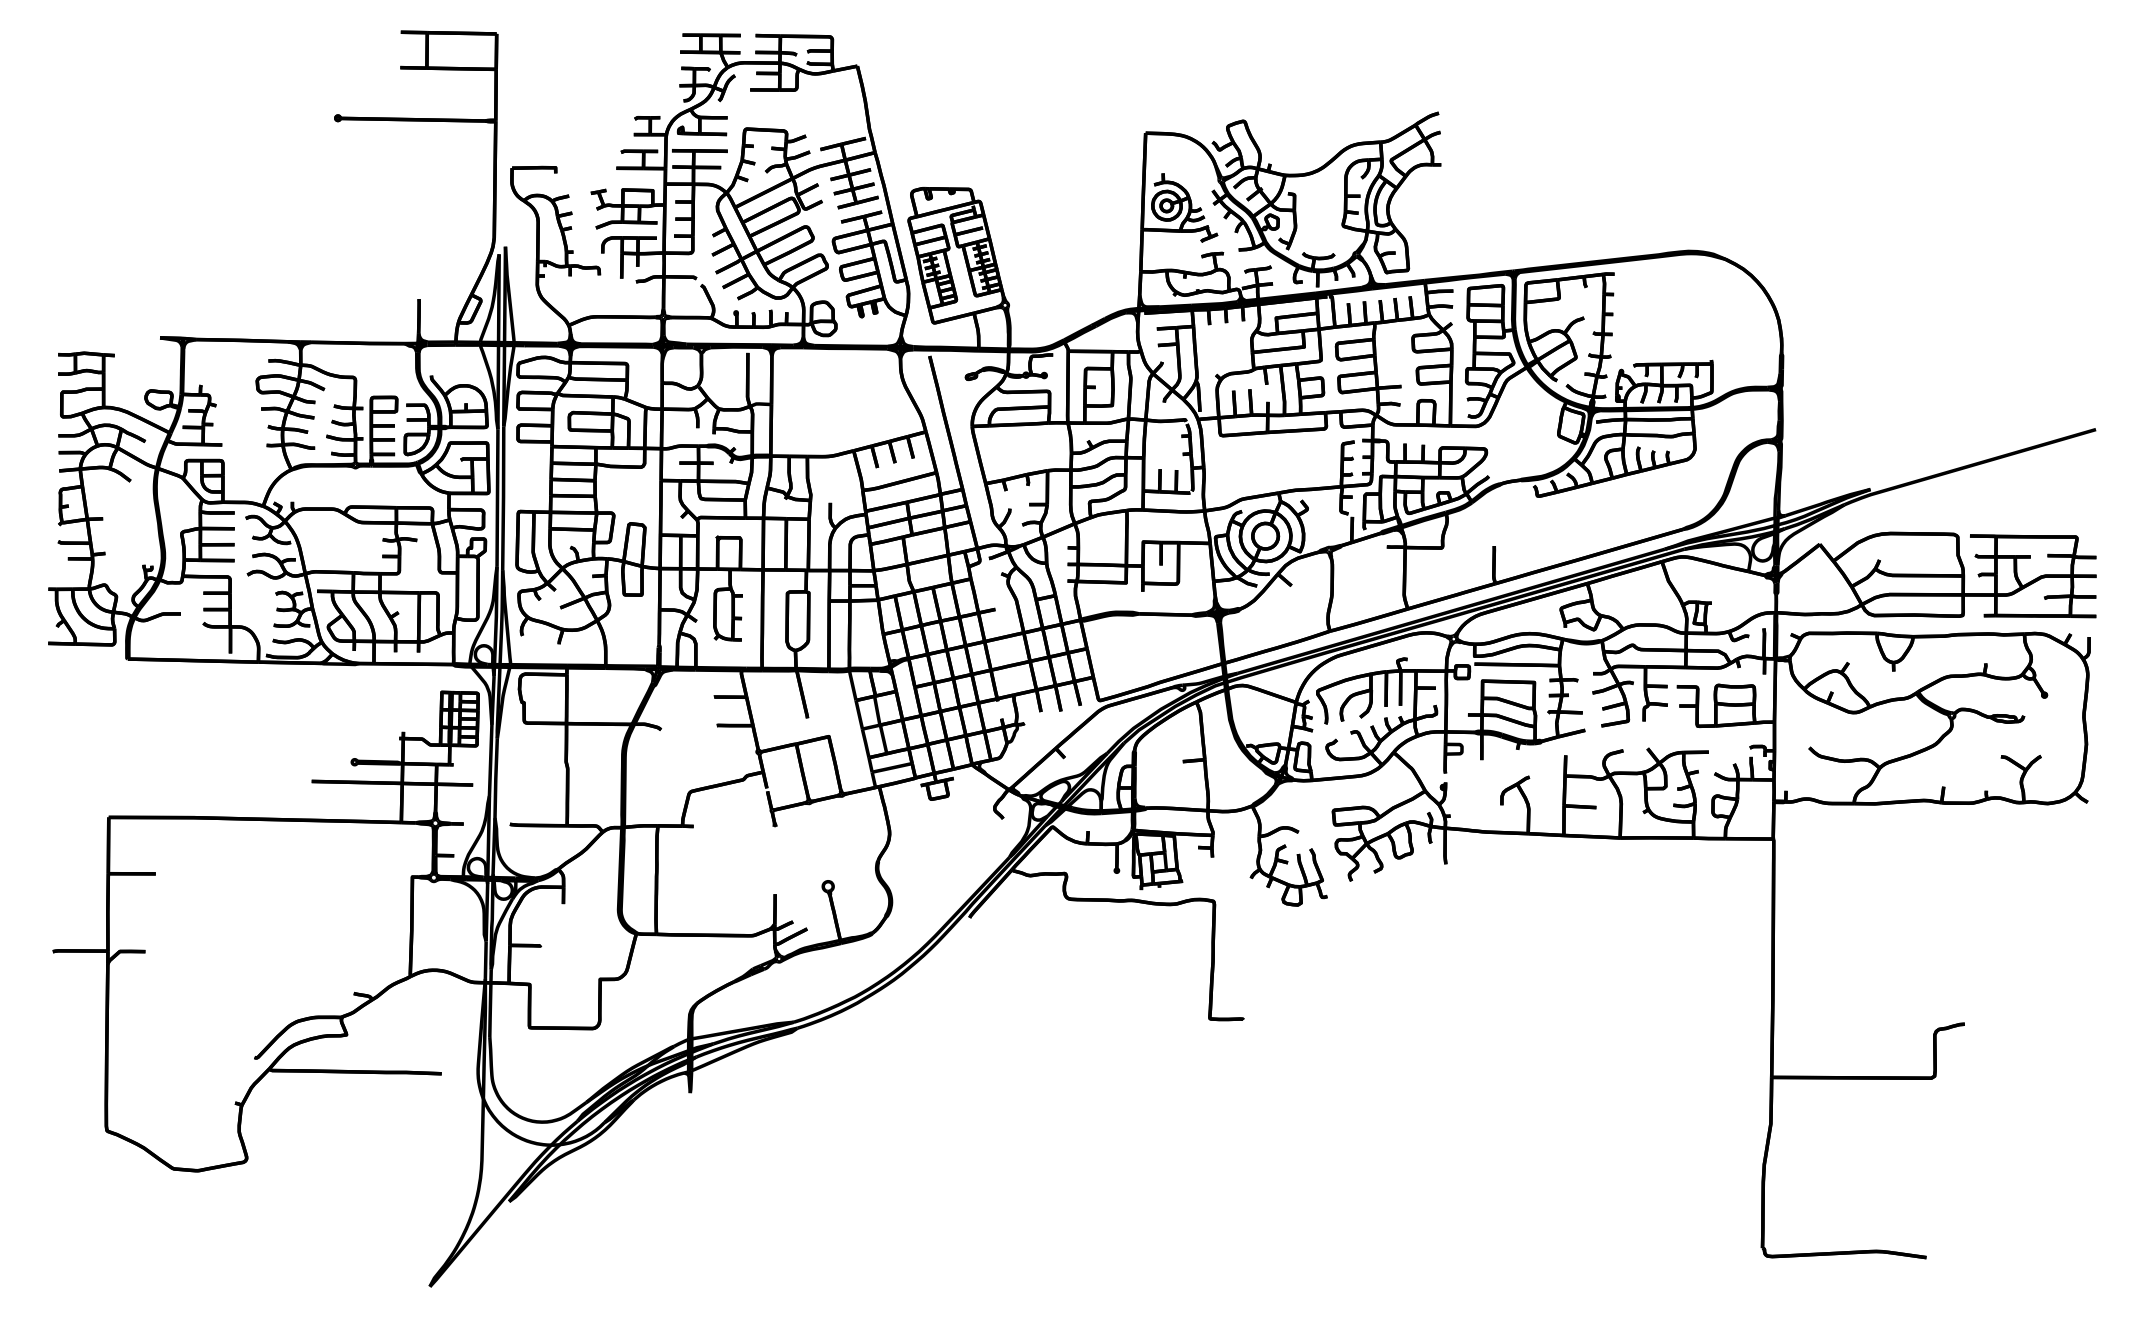

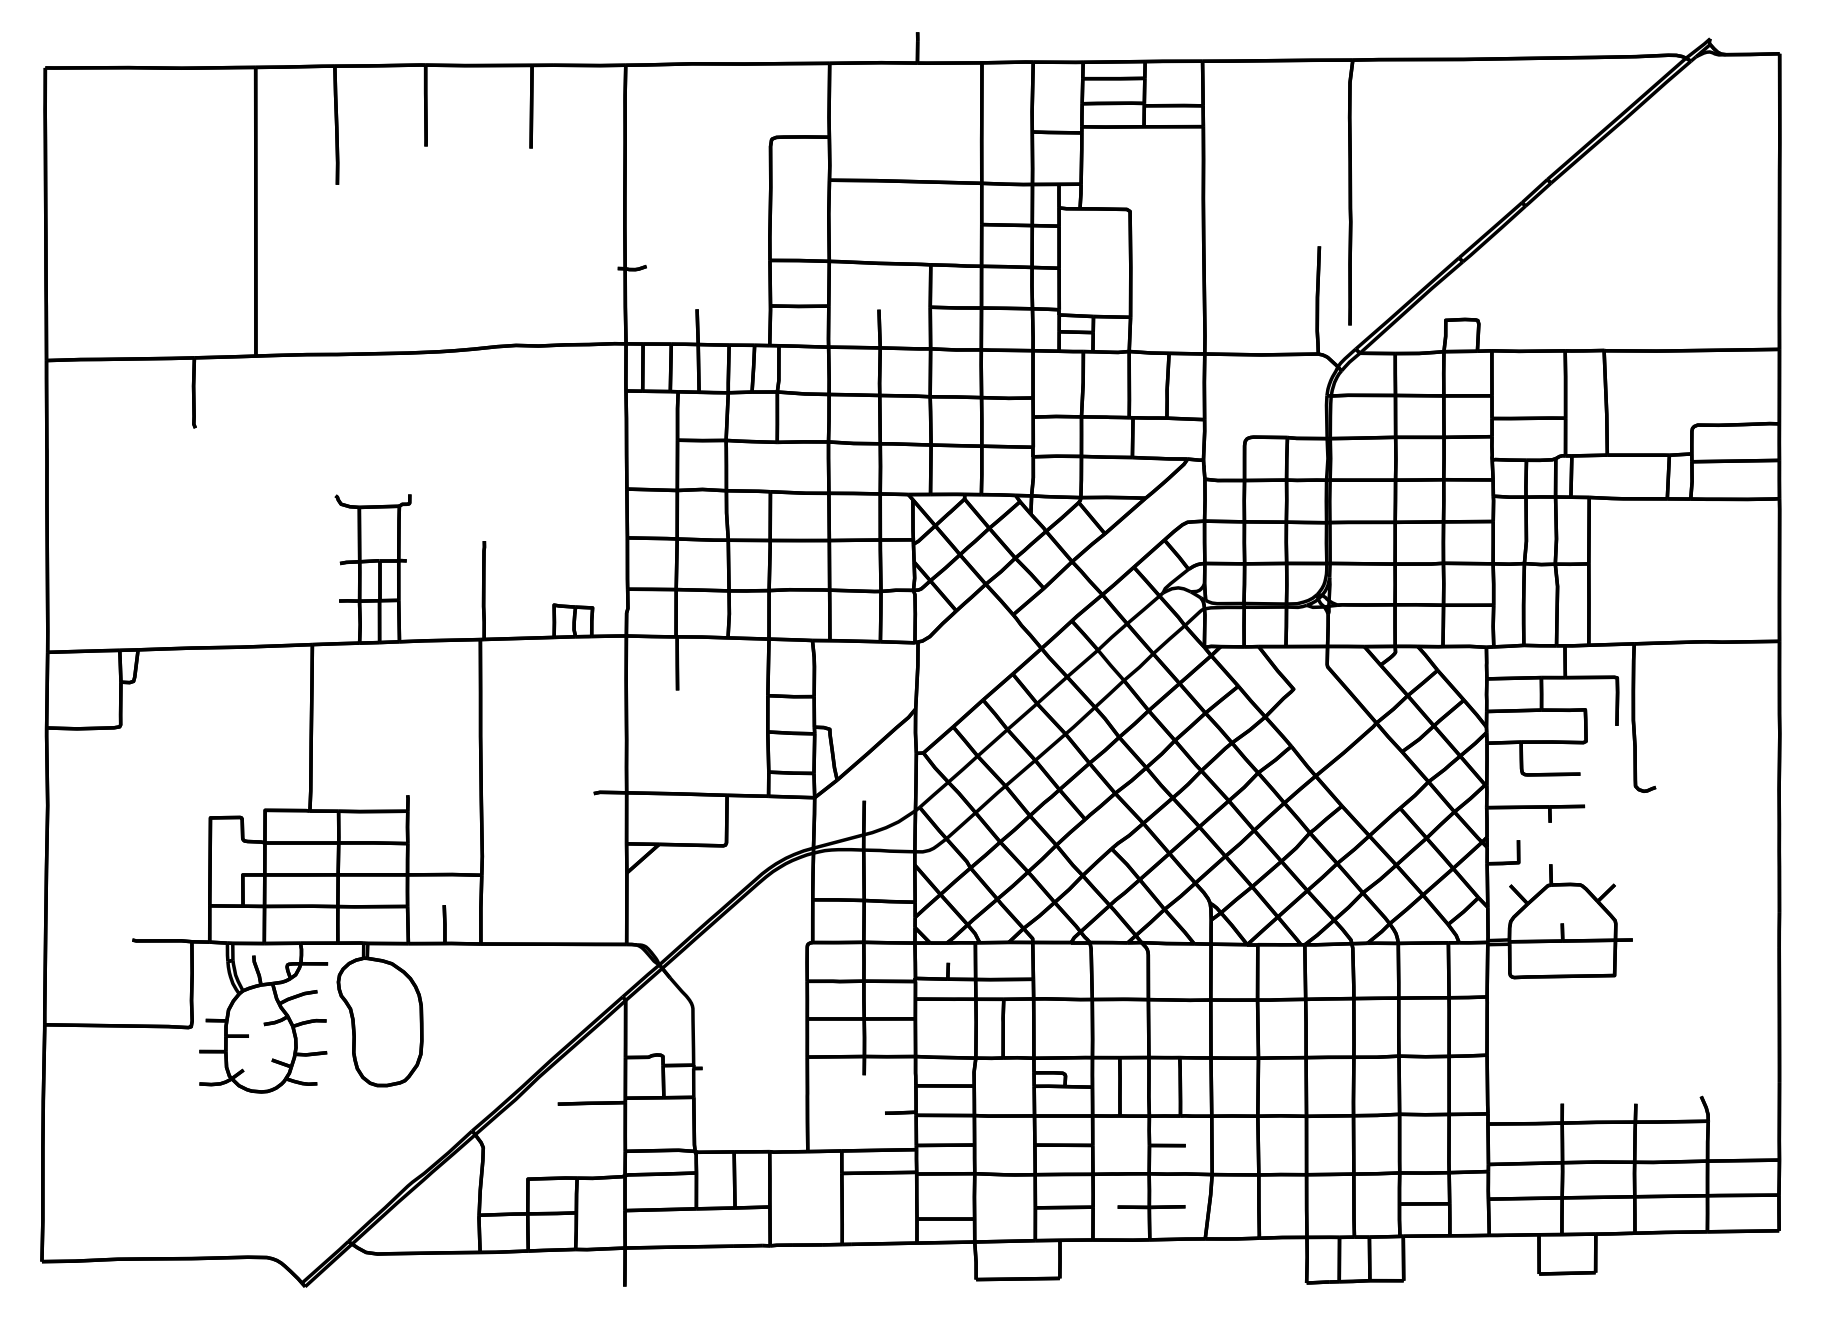

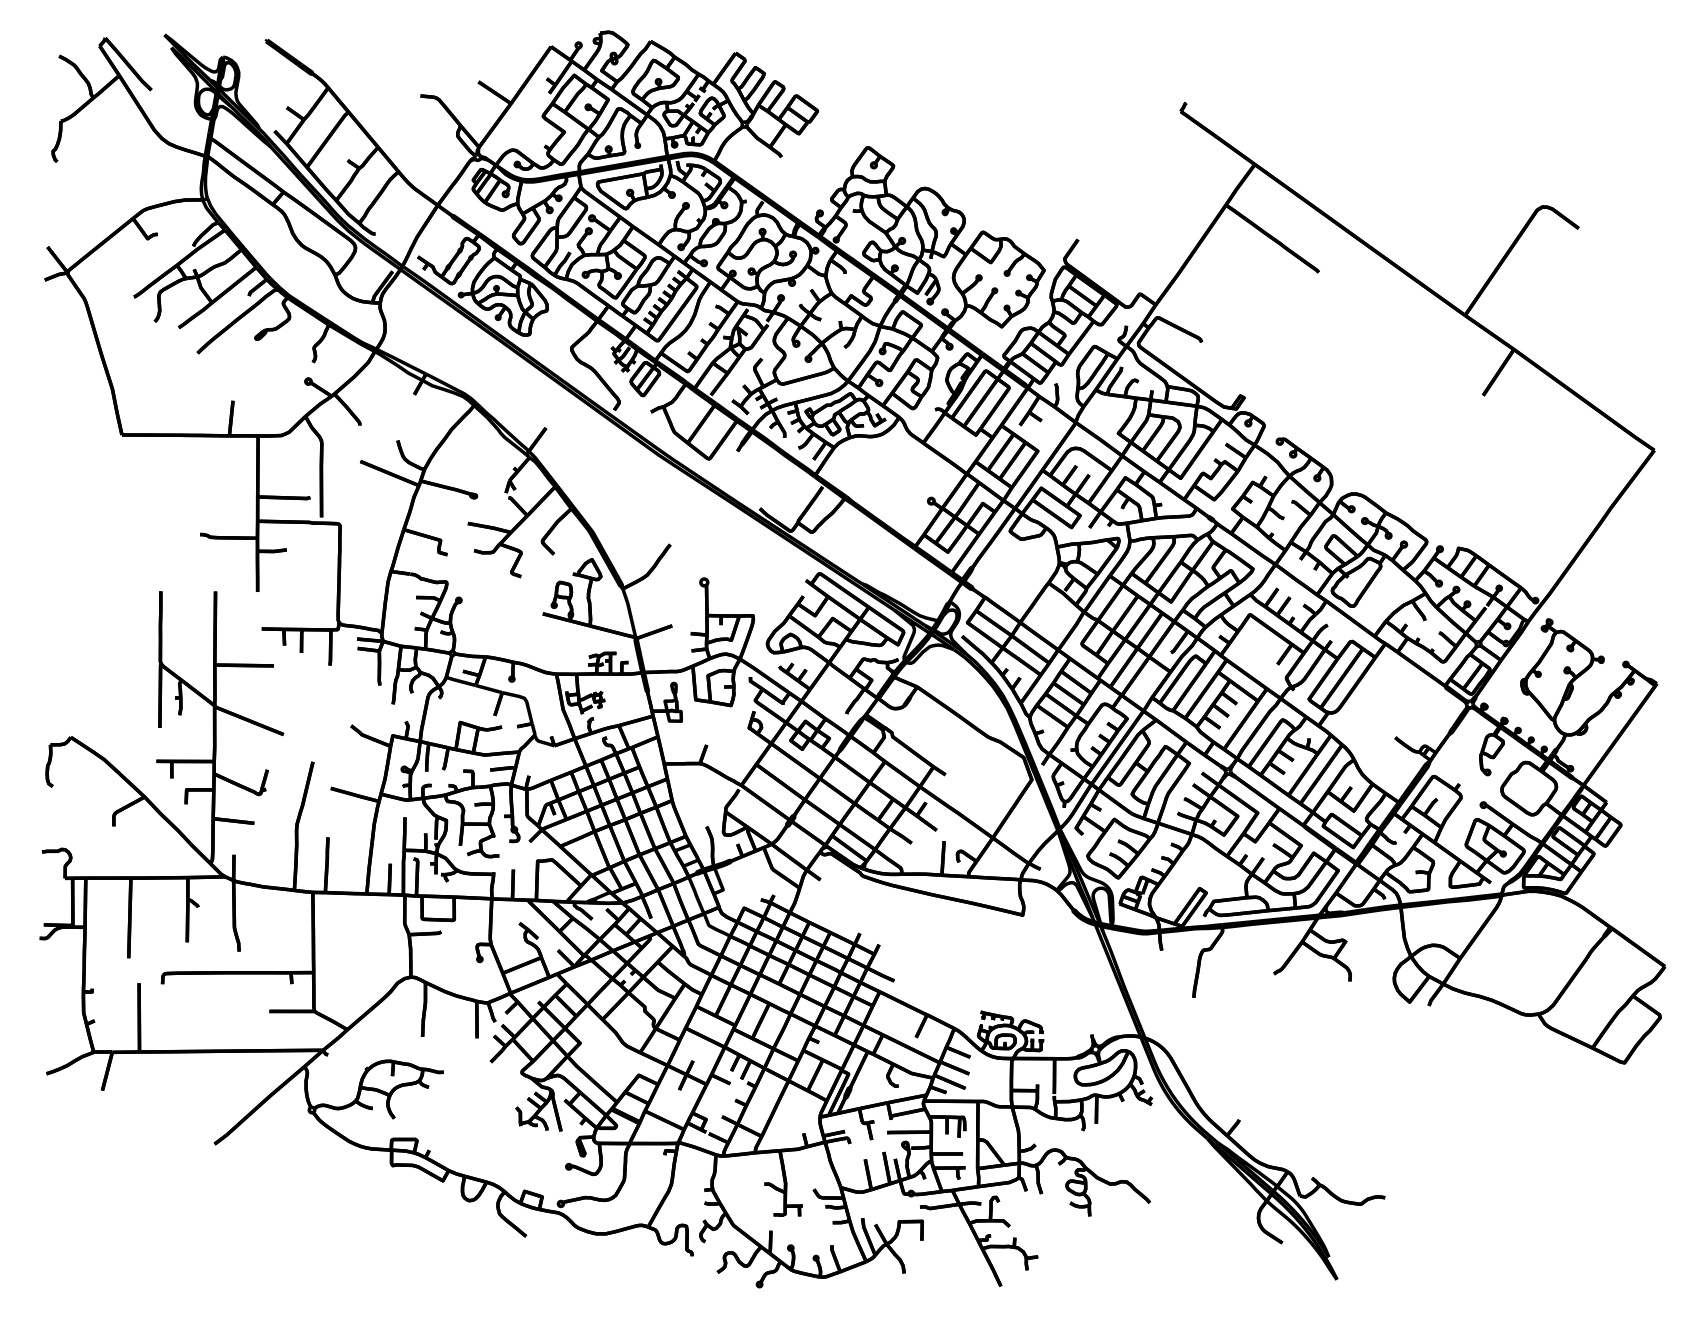

In [16]:
fix, ax = ox.plot_graph(Davis_G, figsize=(40,24), node_size=0,
                        edge_linewidth=3.5, edge_color='k', 
                        show=False, close=False, bgcolor='w')

plt.show()
plt.close()

fix, ax = ox.plot_graph(Portales_G, figsize=(40,24), node_size=0,
                        edge_linewidth=3.5, edge_color='k', 
                        show=False, close=False, bgcolor='w')

plt.show()
plt.close()

fix, ax = ox.plot_graph(Petaluma_G, figsize=(40,24), node_size=0,
                        edge_linewidth=3.5, edge_color='k', 
                        show=False, close=False, bgcolor='w')

plt.show()
plt.close()

In [18]:
def omit_res_roads(G, city_name):
    G_wo_res = G.copy()
    
    res_roads = []
    removed_nodes = []

    for edge in G_wo_res.edges(keys=True, data=True):
        u,v,k,d = edge
        if d['highway'] == 'residential':
            res_roads.append((u, v, k))

    G_wo_res.remove_edges_from(res_roads)

    isolated_nodes = list(nx.isolates(G_wo_res))
    removed_nodes += isolated_nodes
    
    ## remove islands ##
    # check if the removal resulted in disconnected islands
    undir_G = nx.Graph(G_wo_res)
    nodeset_for_subgraphs = list(nx.connected_components(undir_G))
    num_subgraphs = len(nodeset_for_subgraphs)

    # if there are islands, sum the 'aggr_node_num' value in the nodes in each island and  
    # distribute the summed value to the adjacent nodes remaining in the main road network
    if num_subgraphs > 1:
        nodeset_for_largest_subgraph = max(nodeset_for_subgraphs) # the main network
        for nodeset in nodeset_for_subgraphs:
            if nodeset != nodeset_for_largest_subgraph: # if this subgraph is an island
                edges_in_subgraph = []
                for removing_node in nodeset:
                    removing_node_incidents = list(G.out_edges(removing_node, keys=True)) + list(G.in_edges(removing_node, keys=True))
                    edges_in_subgraph += removing_node_incidents

                edges_in_subgraph = list(set(edges_in_subgraph))
                res_roads += edges_in_subgraph
                
                G_wo_res.remove_nodes_from(nodeset)
    
    G_wo_res.remove_nodes_from(isolated_nodes)
    
    print(city_name, 'road network w/o residential roads')
    print(' - Number of nodes:', G_wo_res.number_of_nodes())
    print(' - Number of edges:', G_wo_res.number_of_edges())
    
    return G_wo_res, res_roads, removed_nodes

In [18]:
# load entire graph
Davis_G_wo_res, Davis_res_roads, Davis_res_removed_nodes = omit_res_roads(Davis_G, 'Davis')
Portales_G_wo_res, Portales_res_roads, Portales_res_removed_nodes = omit_res_roads(Portales_G, 'Portales')
Petaluma_G_wo_res, Petaluma_res_roads, Petaluma_res_removed_nodes = omit_res_roads(Petaluma_G, 'Petaluma')

Davis road network w/o residential roads
 - Number of nodes: 782
 - Number of edges: 1448
Portales road network w/o residential roads
 - Number of nodes: 402
 - Number of edges: 821
Petaluma road network w/o residential roads
 - Number of nodes: 633
 - Number of edges: 1164


In [7]:
def simplify(input_G):
    # define edge segment attributes to sum upon edge simplification
    attrs_to_sum = {"length", "travel_time"}
    
    # keep track of removed edges
    removed_edges = []
    removed_nodes = []
    
    acc_multi_edges = []
    acc_selfloops = []
    acc_dead_ends = []

    # make a copy to not mutate original graph object caller passed in
    G = input_G.copy()
     
    not_converged = True
    
    node_num = G.number_of_nodes()
    edge_num = G.number_of_edges()
    G_stat = (node_num, edge_num)
    
    cnt = 0
    
    print('Initial stat (nodes, edges):', G_stat)
    
    nx.set_node_attributes(G, float(1), 'aggr_node_num')
           
    while not_converged:
        
        # keep track of removed edges in this iteration
        removed_edges_per_iteration = []
        
        ## Remove multi-edges ##
        multi_edges = []
        multi_edge_removed_pair = set()
        
        for u,v,k,d in G.edges(data=True, keys=True):
            if (u,v) not in multi_edge_removed_pair:
                all_edges_btwn_nodes = list(G.get_edge_data(u,v).items())
                edge_dat_sorted_by_length = sorted(all_edges_btwn_nodes, reverse=False, key= lambda d: d[1]['length'])
                shortest_edge_key = edge_dat_sorted_by_length[0][0]
                multi_edge_removed_pair.add((u,v))
                
                for key, data in G.get_edge_data(u,v).items():
                    if key != shortest_edge_key:
                        multi_edges.append((u, v, key))
        
        # Record which edge chunks are going to be removed at this iteration
        for edge in multi_edges:
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                ### test purpose
                acc_multi_edges = acc_multi_edges + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
                ### test purpose
                acc_multi_edges.append(edge)
                    
        # remove all the edges whose key is not 0
        G.remove_edges_from(multi_edges)

        ## Remove selfloops ##
        selfloops = list(nx.selfloop_edges(G, keys=True))
        
        for edge in selfloops:               
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                ### test purpose
                acc_selfloops = acc_selfloops + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
                ### test purpose
                acc_selfloops.append(edge)

        G.remove_edges_from(selfloops)
        
    
        ## Remove dead-ends ##
        for _ in range(0,20):
            dead_ends = []
            
            st_cnt = ox.utils_graph.count_streets_per_node(G, nodes=None)
            nx.set_node_attributes(G, st_cnt, 'street_count')

            rm = []

            for node in G.nodes:
                if G.nodes[node]['street_count'] == 1:
                    rm.append(node)
                    dead_ends = dead_ends + list(G.in_edges(node, keys=True)) + list(G.out_edges(node, keys=True))
                    
            dead_ends = list(set(dead_ends))
            
            for edge in dead_ends:
                if 'consolidated_edges' in G.edges[edge]:
                    cons_edges = G.edges[edge]['consolidated_edges']
                    removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                    ### test purpose
                    acc_dead_ends = acc_dead_ends + cons_edges
                else:
                    removed_edges_per_iteration.append(edge)
                    ### test purpose
                    acc_dead_ends.append(edge)
            
            # Add the number of aggregated nodes to its the only neighbor
            for node in rm:
                aggr_node_num = G.nodes[node]['aggr_node_num']
                
                suc = list(G.successors(node))  #  edge from node to neighbors 
                pre_suc = list(G.predecessors(node))  #  edge from neighbors to node
                
                if len(suc) != 0:
                    neighbor_node = suc[0]
                else:
                    neighbor_node = pre_suc[0]
                                
                G.nodes[neighbor_node]['aggr_node_num'] += aggr_node_num
            
            G.remove_nodes_from(rm)
            removed_nodes += rm
            
            
        ## Remove gridiron nodes ##
        gridiron_nodes = []
        gridiron_cand = []
        nx.set_node_attributes(G, False, 'gridiron_cand')
        incident_edges = []
        disconnected_gridiron_nodes = []
        max_len = 300
        
        for node in G.nodes:
            deg = G.degree[node]
            num_neighbors = len(list(G.neighbors(node)))
            if num_neighbors == 4:
                incidents = list(G.out_edges(node, keys=True)) + list(G.in_edges(node, keys=True))
                residential = True
                isCand = False
                
                incident_length = []
                for edge in incidents:
                    road_type = G.edges[edge]['highway']
                    edge_length = G.edges[edge]['length']
                    incident_length.append(edge_length)
                    
                    if road_type != 'residential':
                        residential = False
                        
                if max_len > max(incident_length):
                    isCand = True

                if residential and isCand:
                    G.nodes[node]["gridiron_cand"] = True
                    gridiron_cand.append(node)
        
        for node in gridiron_cand:
            incidents = list(G.out_edges(node, keys=True)) + list(G.in_edges(node, keys=True))
            isGrid = False
            for adj_node in G.neighbors(node):
                if G.nodes[adj_node]['gridiron_cand']:
                    isGrid = True
            if isGrid:
                gridiron_nodes.append(node)
                incident_edges += incidents
                
        incident_edges = list(set(incident_edges))
        for edge in incident_edges:
            if 'consolidated_edges' in G.edges[edge]:
                cons_edges = G.edges[edge]['consolidated_edges']
                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
            else:
                removed_edges_per_iteration.append(edge)
        
        for node in gridiron_nodes:
            # skip this iteration if the node is already removed
            if node in disconnected_gridiron_nodes: continue
            
            # track regional node density
            adjacent_nodes = set(G.neighbors(node))
            if node in adjacent_nodes:
                adjacent_nodes.remove(node)
            adj_node_num = len(adjacent_nodes)
            aggr_val =  G.nodes[node]['aggr_node_num']
            
            
            for adj_node in adjacent_nodes:
                G.nodes[adj_node]['aggr_node_num'] += (aggr_val / adj_node_num)
            
            # remove a gridiron node
            removed_nodes.append(node)
            G.remove_node(node)
            
            # check if the removal resulted in disconnected islands
            undir_G = nx.Graph(G)
            nodeset_for_subgraphs = list(nx.connected_components(undir_G))
            num_subgraphs = len(nodeset_for_subgraphs)
            
            # if there are islands, sum the 'aggr_node_num' value in the nodes in each island and  
            # distribute the summed value to the adjacent nodes remaining in the main road network
            if num_subgraphs > 1:
                nodeset_for_largest_subgraph = max(nodeset_for_subgraphs)
                adjacent_nodes_in_largest_subgraph = []
                
                for adj_node in adjacent_nodes:
                    if adj_node in nodeset_for_largest_subgraph:
                        adjacent_nodes_in_largest_subgraph.append(adj_node)
                        
                adj_node_num_in_largest_subgraph = len(adjacent_nodes_in_largest_subgraph)
                
                for nodeset in nodeset_for_subgraphs:
                    if nodeset != nodeset_for_largest_subgraph: # if this subgraph is an island
                        removed_nodes += nodeset
                        aggr_sum = 0
                        for node_in_subgraph in nodeset:
                            aggr_sum += G.nodes[node_in_subgraph]['aggr_node_num']
                        
                        for adj_node in adjacent_nodes_in_largest_subgraph:
                            G.nodes[adj_node]['aggr_node_num'] += (aggr_sum / adj_node_num_in_largest_subgraph)
                        
                        edges_in_subgraph = []
                        for removing_node in nodeset:
                            if removing_node in gridiron_nodes:
                                disconnected_gridiron_nodes.append(removing_node)
                                
                            removing_node_incidents = list(G.out_edges(removing_node, keys=True)) + list(G.in_edges(removing_node, keys=True))
                            edges_in_subgraph += removing_node_incidents
                            
                        edges_in_subgraph = list(set(edges_in_subgraph))

                        for edge in edges_in_subgraph:
                            if 'consolidated_edges' in G.edges[edge]:
                                cons_edges = G.edges[edge]['consolidated_edges']
                                removed_edges_per_iteration = removed_edges_per_iteration + cons_edges
                            else:
                                removed_edges_per_iteration.append(edge)
                            
                        G.remove_nodes_from(nodeset)
                                
        ## Remove interstitial nodes ##
        all_nodes_to_remove = []
        all_edges_to_add = []
        processed_path = []
        
        # generate each path that needs to be simplified
        for path in ox.simplification._get_paths_to_simplify(G, strict=True):            
            # add the interstitial edges we're removing to a list so we can retain
            # their spatial geometry
            path_attributes = dict()
            edges_in_path = []
            
            path_aggr_node_num = 0
            org_node = path[0]
            dst_node = path[-1]
            
            for node in path[1:-1]: # interstitial nodes
                node_aggr_node_num = G.nodes[node]['aggr_node_num']
                path_aggr_node_num += node_aggr_node_num
            
            end_points = {org_node, dst_node}
            interstitial_nodes = set(path[1:-1])
            
            if org_node == dst_node: # i.e. self-loop (set "end_points" above has only one element)
                path_aggr_node_num = 2 * path_aggr_node_num
                
            nodes_on_path = (end_points, interstitial_nodes)
            
            # there may be reverse path that goes through the same nodes
            # avoid path_aggr_node_num being summed twice
            if nodes_on_path not in processed_path:
                processed_path.append(nodes_on_path)
                for node in end_points:
                    G.nodes[node]['aggr_node_num'] += (path_aggr_node_num / 2)
                                
            for u, v in zip(path[:-1], path[1:]):
                
                # get edge between these nodes. Multi-edges do not exist since already removed
                edge_key_and_data = tuple(G.get_edge_data(u, v).items())[0]
                edge_key = edge_key_and_data[0]
                exact_edge = (u,v, edge_key)
                edge_data = edge_key_and_data[1]
                edges_in_path.append(exact_edge)
                
                for attr in edge_data:
                    if attr in path_attributes:
                        # if this key already exists in the dict, append it to the
                        # value list
                        dat_val = edge_data[attr]
                        if type(dat_val) == list:
                            path_attributes[attr] = path_attributes[attr] + edge_data[attr]
                        else:
                            path_attributes[attr].append(edge_data[attr])
                    else:
                        # if this key doesn't already exist, set the value to a list
                        # containing the one value
                        dat_val = edge_data[attr]
                        if type(dat_val) == list:
                            path_attributes[attr] = edge_data[attr]
                        else:
                            path_attributes[attr] = [edge_data[attr]]
                
            # consolidate the path's edge segments' attribute values
            for attr in path_attributes:
                if attr in attrs_to_sum:
                    # if this attribute must be summed, sum it now
                    path_attributes[attr] = sum(path_attributes[attr])
                elif (attr != "geometry") and len(set(path_attributes[attr])) == 1:
                    # if there's only 1 unique value in this attribute list,
                    # consolidate it to the single value (the zero-th):
                    path_attributes[attr] = path_attributes[attr][0]
                elif attr != "geometry":
                    # otherwise, if there are multiple values, keep one of each
                    path_attributes[attr] = list(set(path_attributes[attr]))
            
            # Check consolidated edges are all in the 'consolidated_edges'
            if 'consolidated_edges' not in path_attributes:
                # none of the edges in path is previously consolidated
                # all the exact edges in the path is added to 'consolidated edges'
                path_attributes['consolidated_edges'] = edges_in_path
            else:
                # at least one of the edges in path is previously consolidated
                # previously not consolidated edges need to be added to 'consolidated edges'
                for edge in edges_in_path:
                    if edge in input_G.edges:
                        path_attributes['consolidated_edges'].append(edge)
                                               
            # construct the new consolidated edge's geometry for this path
            if 'geometry' not in path_attributes:
                path_attributes["geometry"] = LineString(
                    [Point((G.nodes[node]["x"], G.nodes[node]["y"])) for node in path]
                )
            else:
                points = []
                geometry = path_attributes['geometry']

                # Gather geometry dataframes in a list
                gm_df = []
                for gm in geometry:
                    x,y = gm.coords.xy
                    df = pd.DataFrame({'x':x,'y':y})
                    gm_df.append(df)

                for node in path:
                    node_x = G.nodes[node]['x']
                    node_y = G.nodes[node]['y']
                    node_coord = (node_x, node_y)
                    node_point = Point(node_coord)
                    #if node_point in points: continue

                    used_df_idx = [] # Prevent using duplicate geometry in reverse=order
                    node_belong_to_gm = False

                    for i, df in enumerate(gm_df):
                        # check if this node has geometry
                        has_gm = ((df['x'] == node_x) & (df['y'] == node_y))

                        # if geometry exists, add all the points in it
                        if has_gm.loc[has_gm.index[0]] and i not in used_df_idx:
                            node_belong_to_gm = True
                            used_df_idx.append(i)
                            for idx, row in df.iterrows():
                                x_coord = row['x']
                                y_coord = row['y']
                                geo_point = Point((x_coord, y_coord))
                                if geo_point not in points: points.append(geo_point)
                        elif has_gm.loc[has_gm.index[-1]] and i not in used_df_idx:
                            node_belong_to_gm = True
                            used_df_idx.append(i)
                            df = df[::-1]
                            for idx, row in df.iterrows():
                                x_coord = row['x']
                                y_coord = row['y']
                                geo_point = Point((x_coord, y_coord))
                                if geo_point not in points: points.append(geo_point)

                    # for node without geometry, simply add its single point
                    if not node_belong_to_gm:
                        points.append(node_point)

                path_attributes["geometry"] = LineString(points)

            # add the nodes and edge to their lists for processing at the end
            all_nodes_to_remove.extend(path[1:-1])
            all_edges_to_add.append(
                {"origin": path[0], "destination": path[-1], "attr_dict": path_attributes}
            )

        # for each edge to add in the list we assembled, create a new edge between
        # the origin and destination
        for edge in all_edges_to_add:
            G.add_edge(edge["origin"], edge["destination"], **edge["attr_dict"])
            
        # finally remove all the interstitial nodes between the new edges
        G.remove_nodes_from(set(all_nodes_to_remove))
        removed_nodes += list(set(all_nodes_to_remove))
        
        # check convergence
        current_node_num = G.number_of_nodes()
        current_edge_num = G.number_of_edges()
        current_stat = (current_node_num, current_edge_num)
        
        if G_stat == current_stat:
            not_converged = False
            break
        else:           
            G_stat = current_stat
            removed_edges.append(removed_edges_per_iteration)
            cnt += 1
        
        print('Stat at iteration', cnt, '(nodes, edges):', G_stat)
            
    print('Graph converged at iteration', cnt)
        
    return G, removed_edges, removed_nodes, (acc_multi_edges, acc_selfloops, acc_dead_ends)

In [26]:
print('Working on city of Davis')
Davis_simple_G, Davis_removed_edges, Davis_removed_nodes, Davis_removed_cat = simplify(Davis_G)
print('Working on city of Portales')
Portales_simple_G, Portales_removed_edges, Portales_removed_nodes, Portales_removed_cat = simplify(Portales_G)
print('Working on city of Petaluma')
Petaluma_simple_G, Petaluma_removed_edges, Petaluma_removed_nodes, Petaluma_removed_cat = simplify(Petaluma_G)

Working on city of Davis
Initial stat (nodes, edges): (2110, 4968)
Stat at iteration 1 (nodes, edges): (1061, 2698)
Stat at iteration 2 (nodes, edges): (980, 2455)
Stat at iteration 3 (nodes, edges): (960, 2398)
Stat at iteration 4 (nodes, edges): (960, 2397)
Graph converged at iteration 4
Working on city of Portales
Initial stat (nodes, edges): (794, 2428)
Stat at iteration 1 (nodes, edges): (409, 1172)
Stat at iteration 2 (nodes, edges): (374, 1095)
Stat at iteration 3 (nodes, edges): (373, 1091)
Graph converged at iteration 3
Working on city of Petaluma
Initial stat (nodes, edges): (2374, 5957)
Stat at iteration 1 (nodes, edges): (1036, 2808)
Stat at iteration 2 (nodes, edges): (904, 2461)
Stat at iteration 3 (nodes, edges): (894, 2431)
Stat at iteration 4 (nodes, edges): (892, 2425)
Graph converged at iteration 4


In [9]:
def plot_graph(
    G,
    ax=None,
    figsize=(8, 8),
    bgcolor="#111111",
    node_color="w",
    node_size=15,
    node_alpha=None,
    node_edgecolor="k",
    node_zorder=1,
    edge_color="#999999",
    edge_linewidth=1,
    edge_alpha=None,
    show=True,
    close=False,
    save=False,
    filepath=None,
    dpi=300,
    bbox=None,
    removed_nodes=None
):

    max_node_size = max(node_size) if hasattr(node_size, "__iter__") else node_size
    max_edge_lw = max(edge_linewidth) if hasattr(edge_linewidth, "__iter__") else edge_linewidth
    if max_node_size <= 0 and max_edge_lw <= 0:  # pragma: no cover
        raise ValueError("Either node_size or edge_linewidth must be > 0 to plot something.")

    # create fig, ax as needed
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize, facecolor=bgcolor, frameon=False)
        ax.set_facecolor(bgcolor)
    else:
        fig = ax.figure

    if max_edge_lw > 0:       
        # plot edges that remaining after simplification
        removed_edges = []
        dup_edge_color = None
        for u,v,k,d in G.edges(data=True, keys=True):
            if 'removed' in d and d['removed'] != 1:
                removed_edges.append((u,v,k))
            else:
                dup_edge_color = edge_color[u][v][k]
        
        dup_G = G.copy()        
        dup_G.remove_edges_from(removed_edges)
        gdf_edges = ox.utils_graph.graph_to_gdfs(dup_G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=dup_edge_color, lw=edge_linewidth, alpha=edge_alpha, zorder=1)
        
        # plot the edges' geometries
        gdf_edges = ox.utils_graph.graph_to_gdfs(G, nodes=False)["geometry"]
        ax = gdf_edges.plot(ax=ax, color=edge_color, lw=edge_linewidth, alpha=edge_alpha, zorder=0)

    # get spatial extents from bbox parameter or the edges' geometries
    padding = 0
    if bbox is None:
        try:
            west, south, east, north = gdf_edges.total_bounds
        except NameError:
            west, south = gdf_nodes.min()
            east, north = gdf_nodes.max()
        bbox = north, south, east, west
        padding = 0.02  # pad 2% to not cut off peripheral nodes' circles

    # configure axis appearance, save/show figure as specified, and return
    ax = ox.plot._config_ax(ax, G.graph["crs"], bbox, padding)
    fig, ax = ox.plot._save_and_show(fig, ax, save, show, close, filepath, dpi)

    return fig, ax

In [10]:
def get_edge_colors(G, removed_edges):
    
    nx.set_edge_attributes(G, 1, 'removed')

    for removed_edge in removed_edges:
        G.edges[removed_edge]['removed'] = 0
    
    ec = ox.plot.get_edge_colors_by_attr(G, 'removed', num_bins=None, cmap='Greys',
                                     start=0.2, stop=1, na_color='none', equal_size=False)
    return ec

In [27]:
temp = []
for edge_list in Davis_removed_edges:
    temp += edge_list
Davis_removed_edges = temp

temp = []
for edge_list in Portales_removed_edges:
    temp += edge_list
Portales_removed_edges = temp

temp = []
for edge_list in Petaluma_removed_edges:
    temp += edge_list
Petaluma_removed_edges = temp

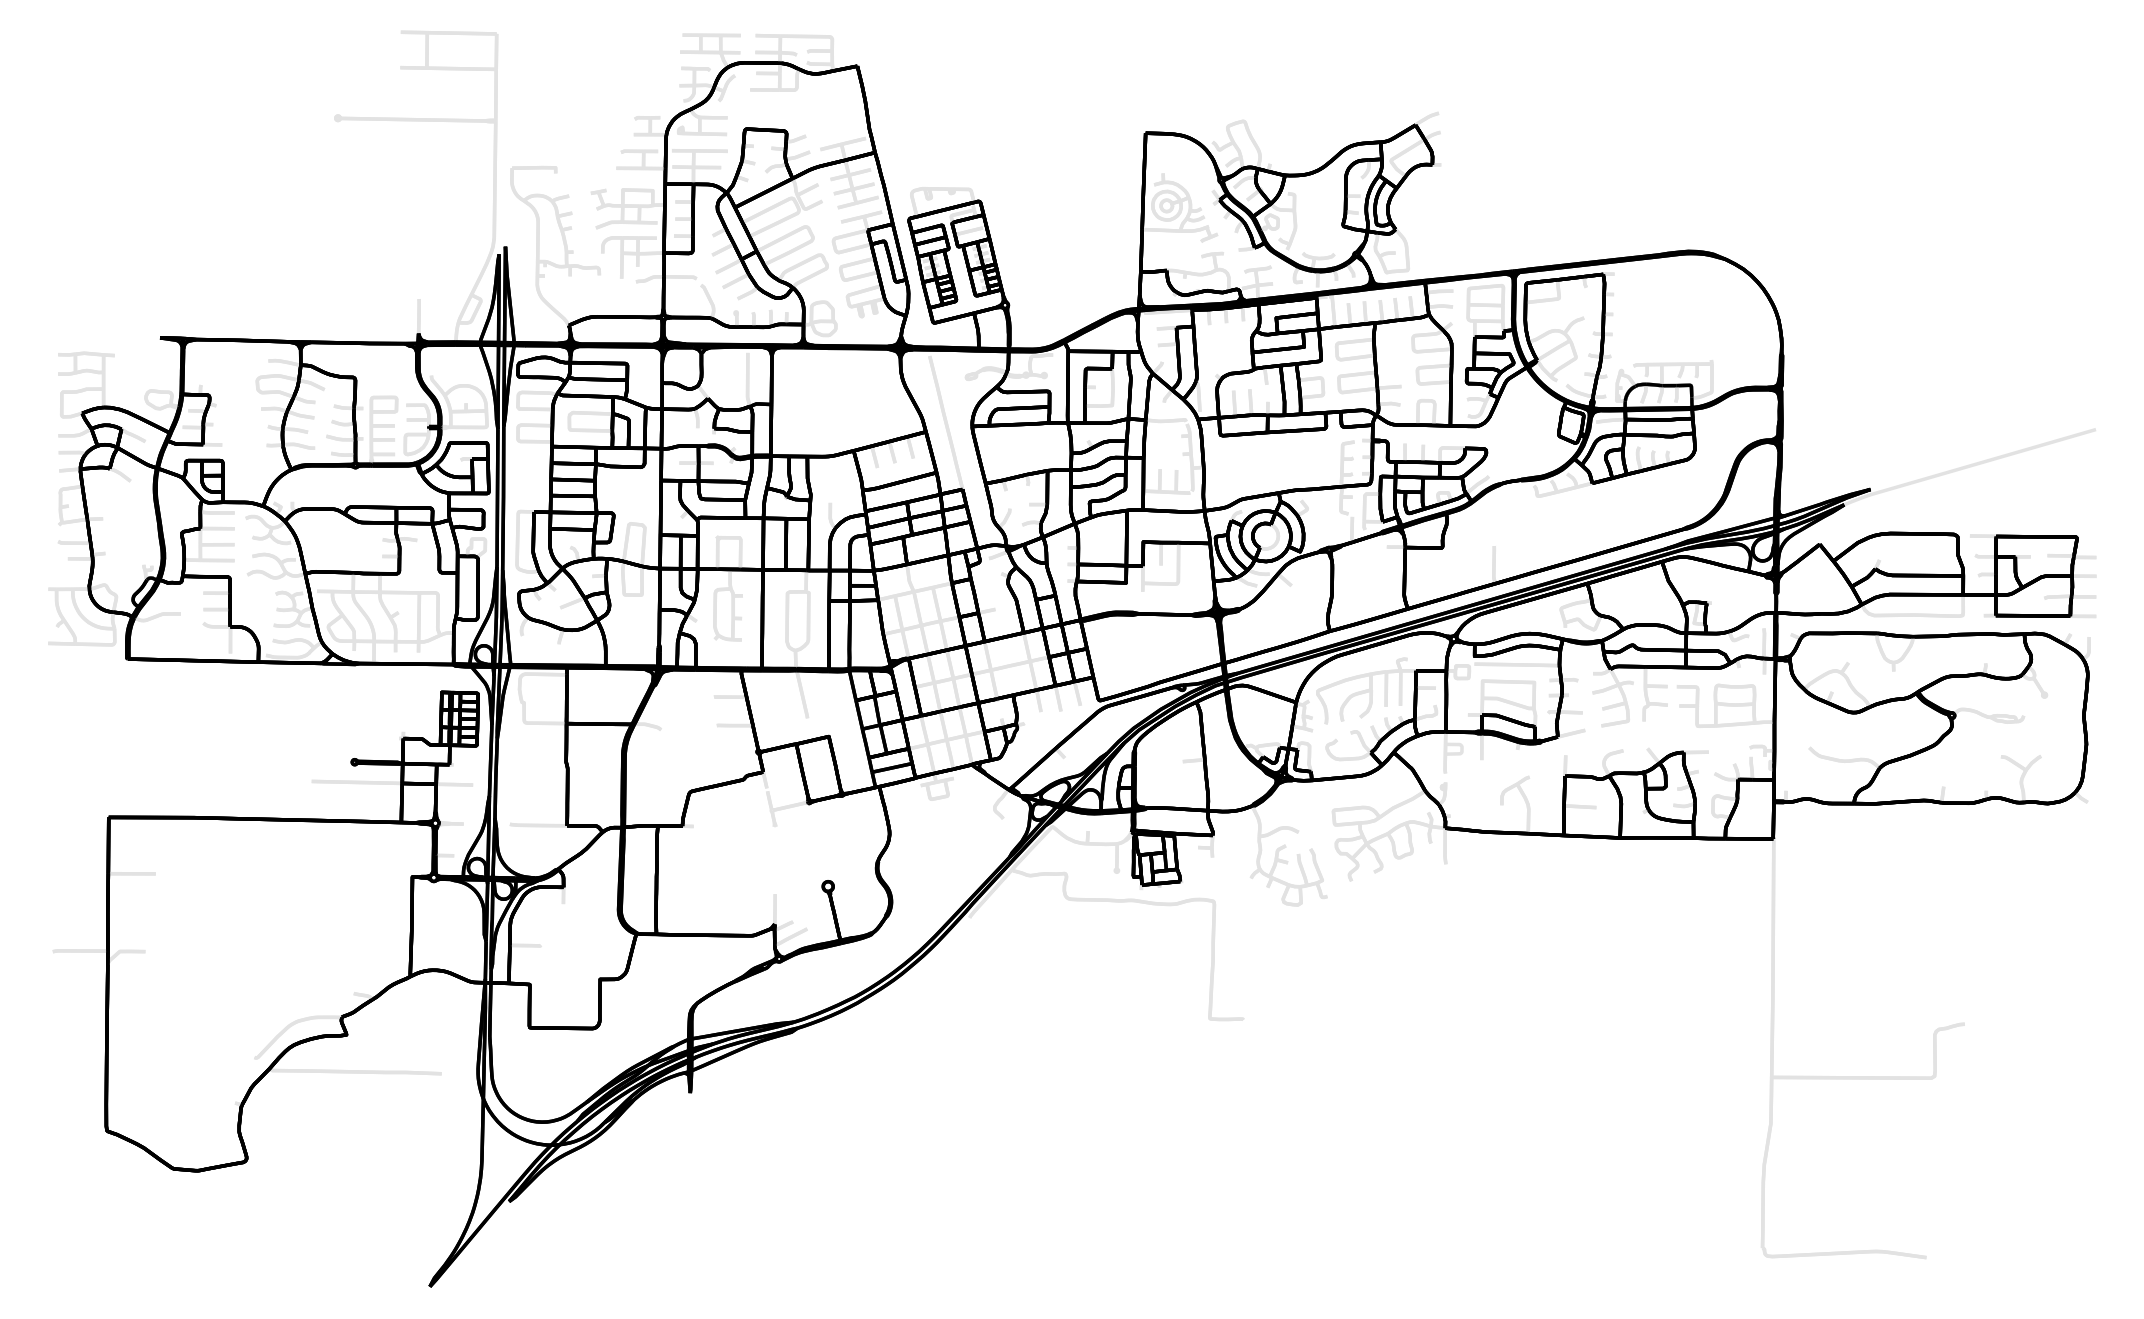

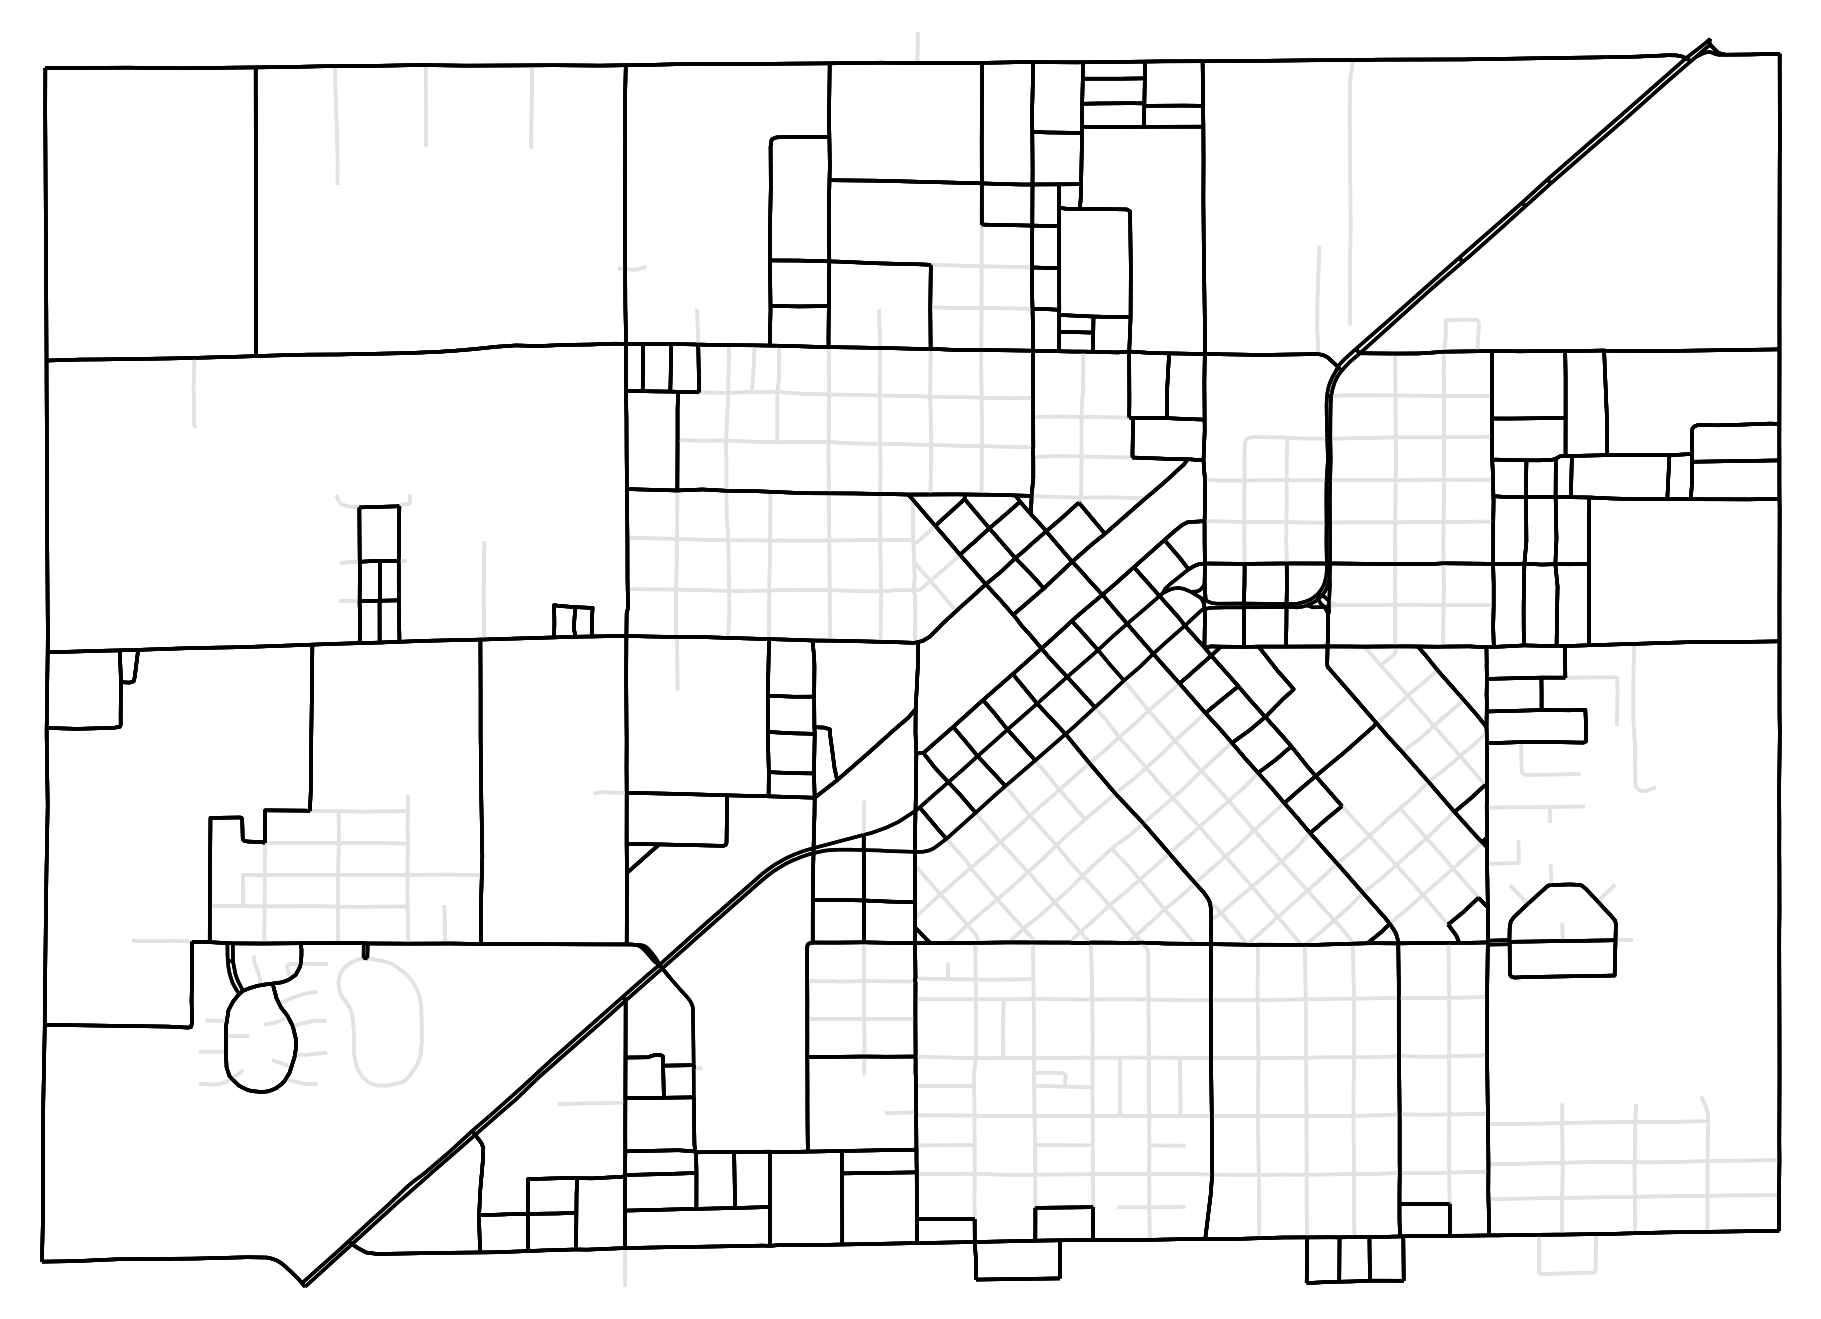

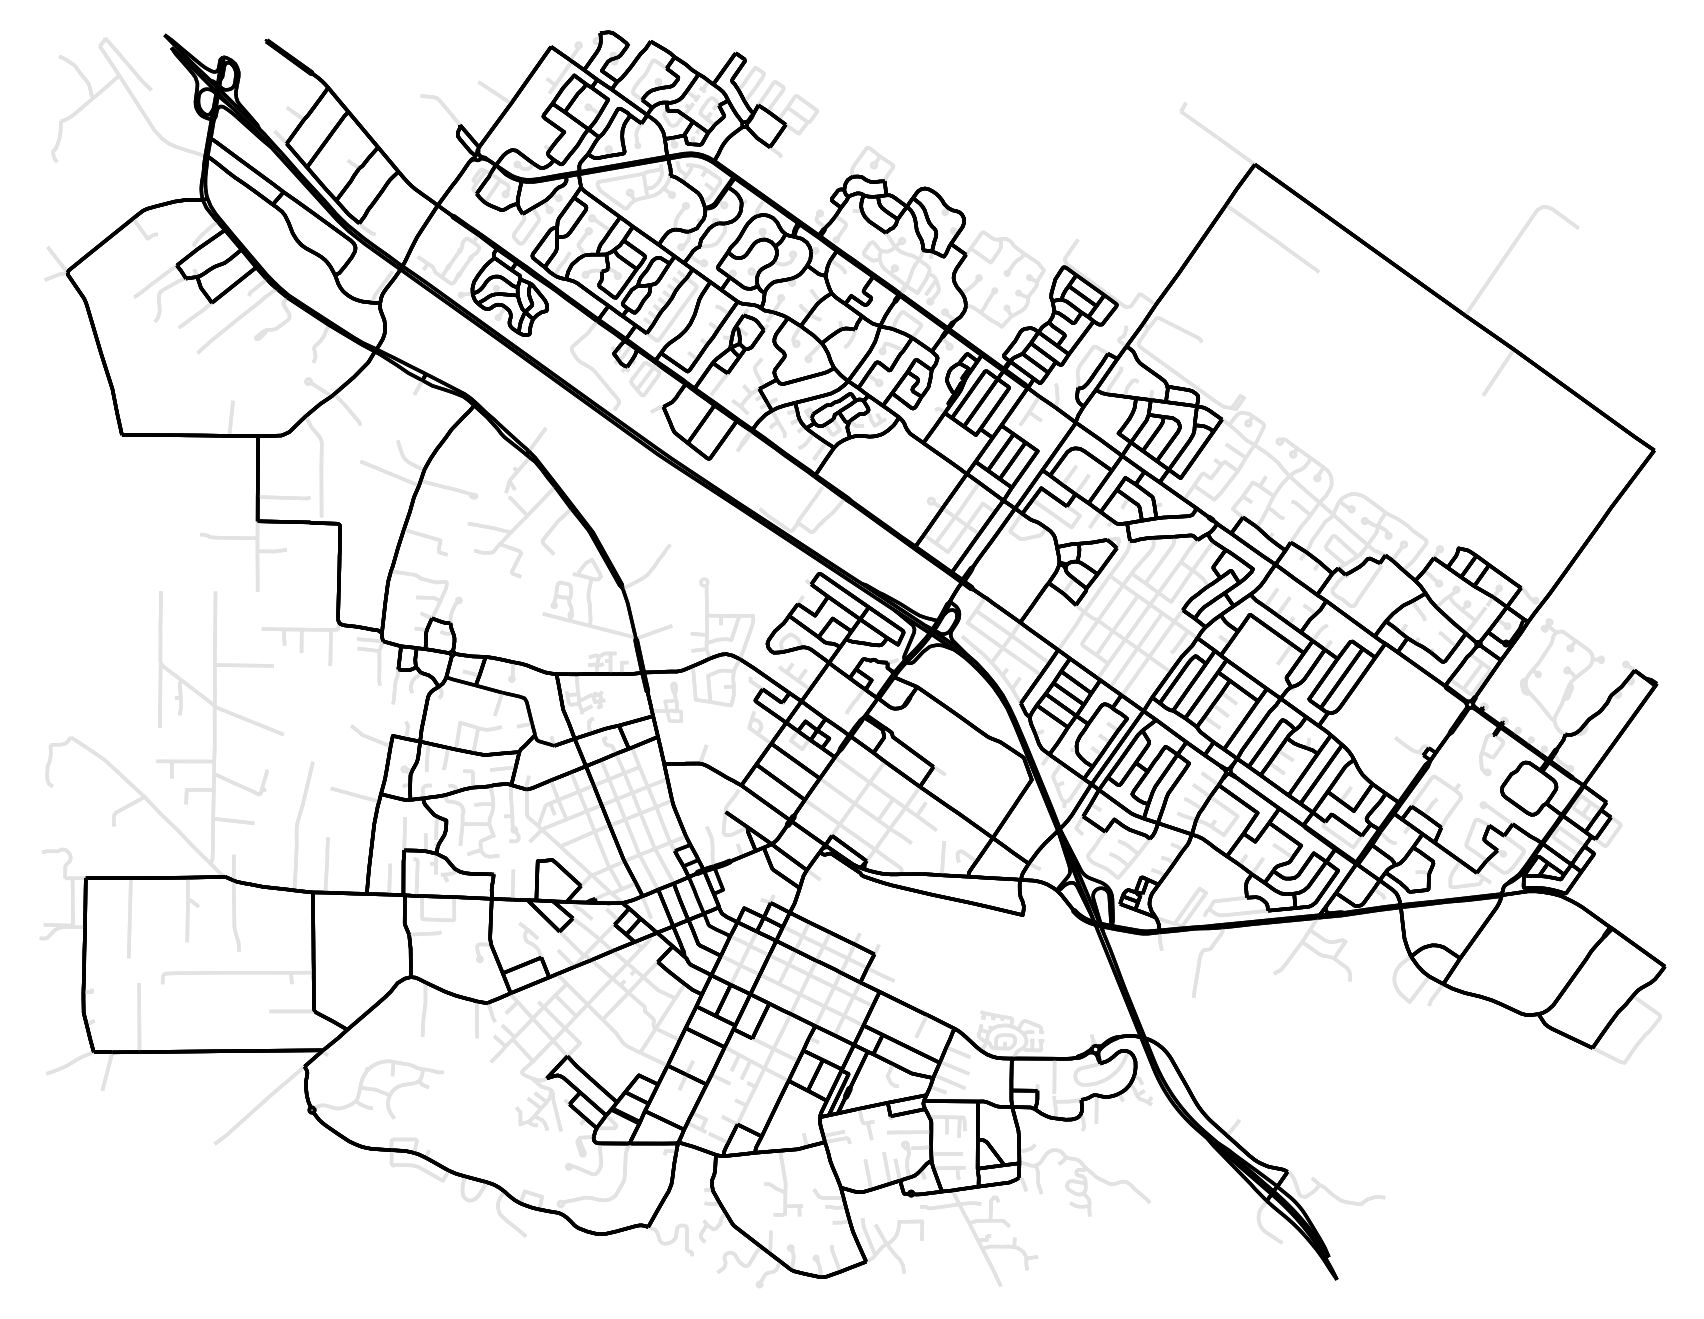

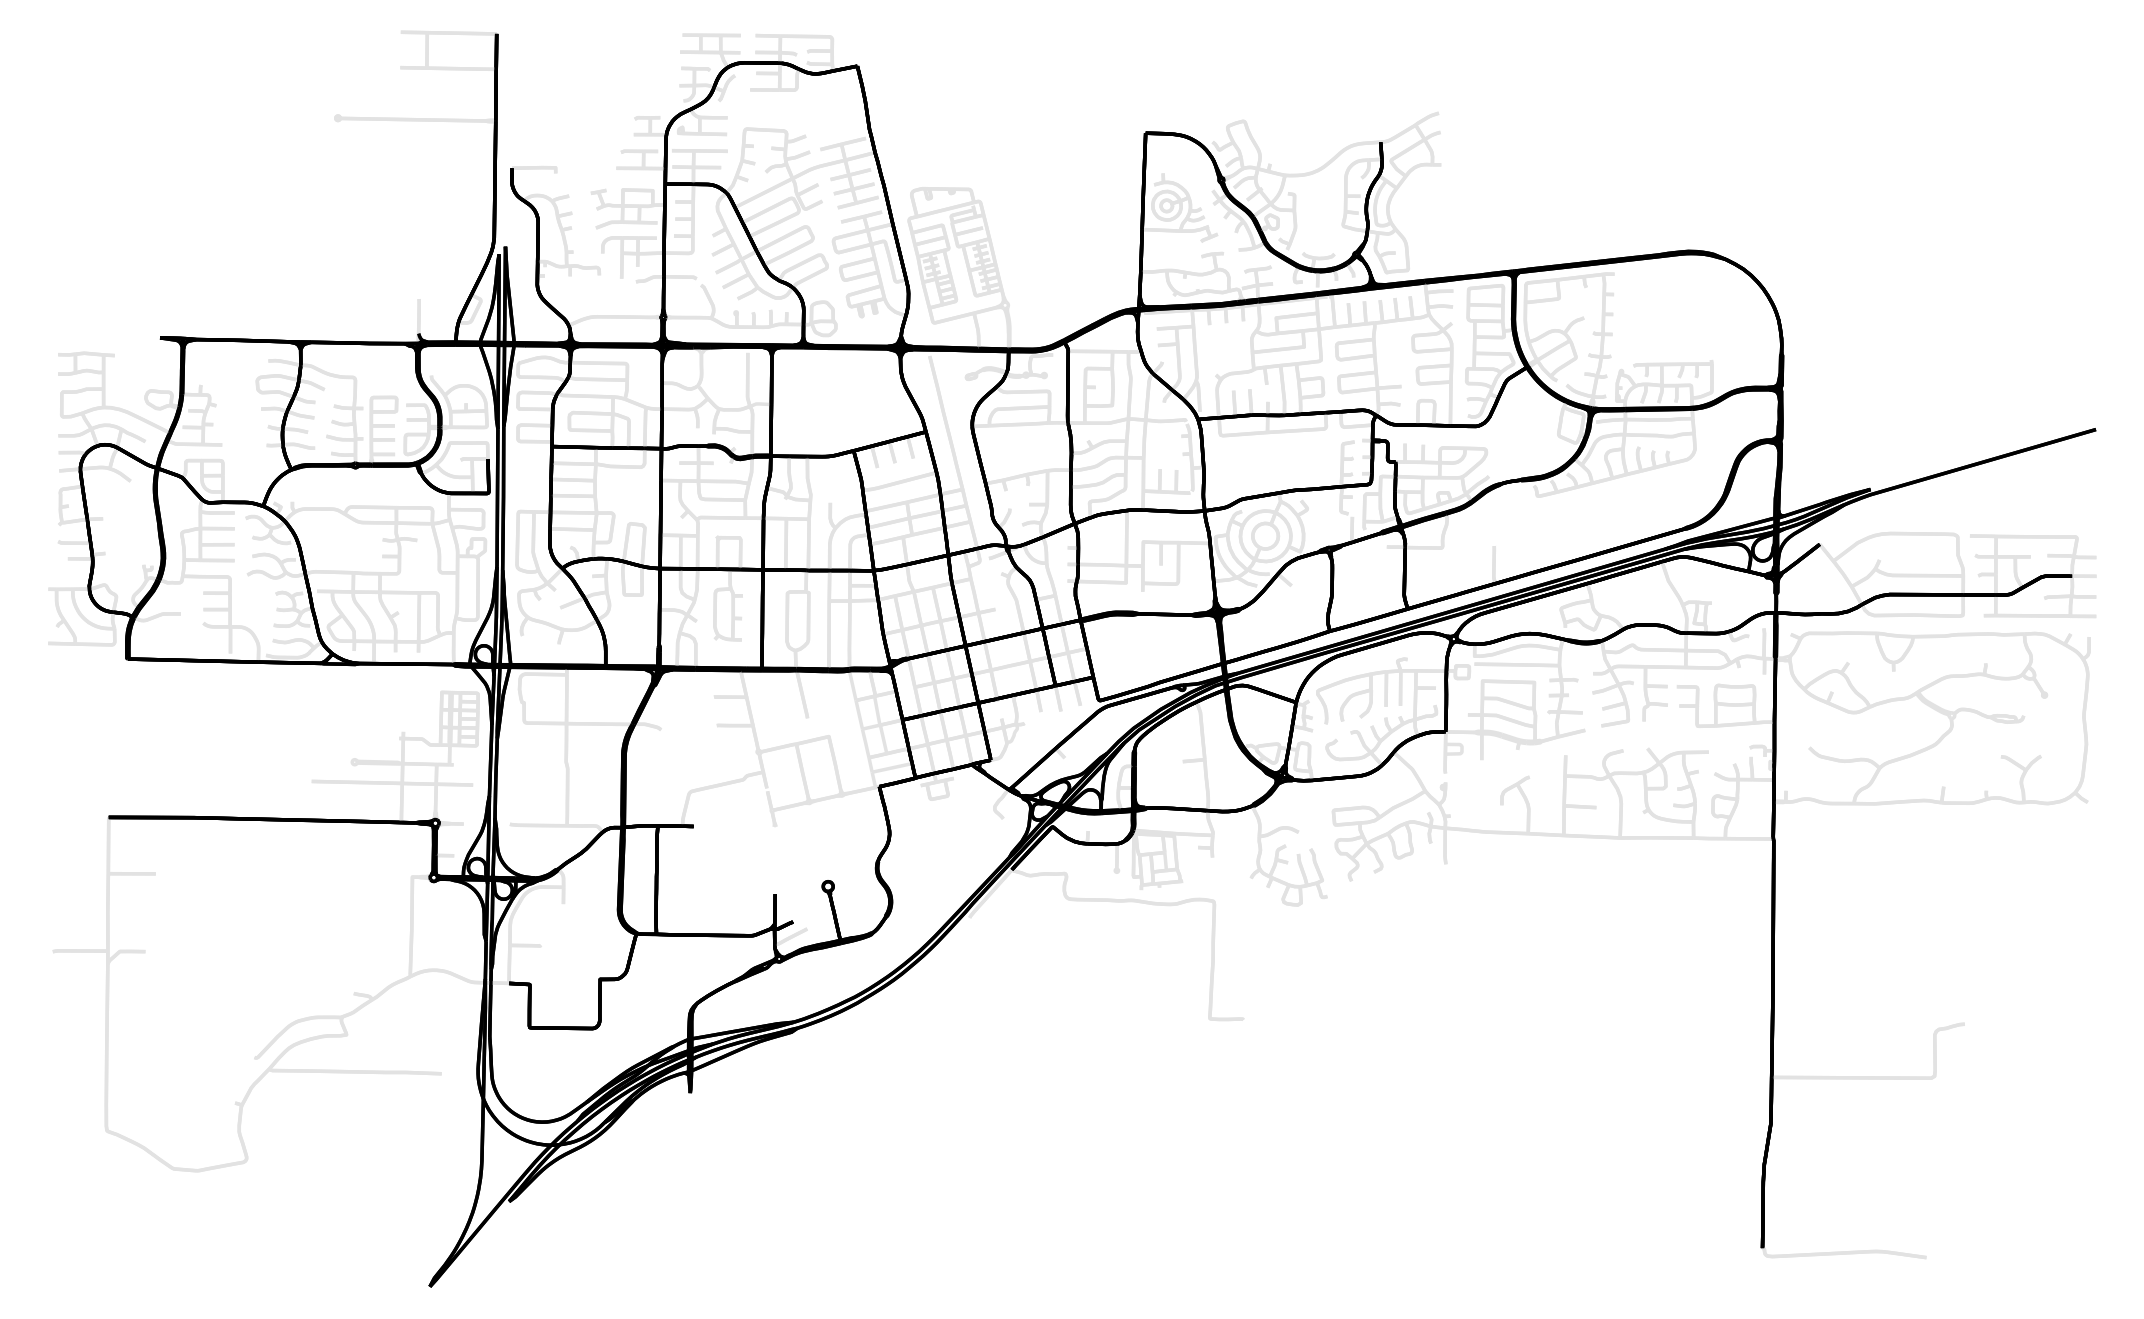

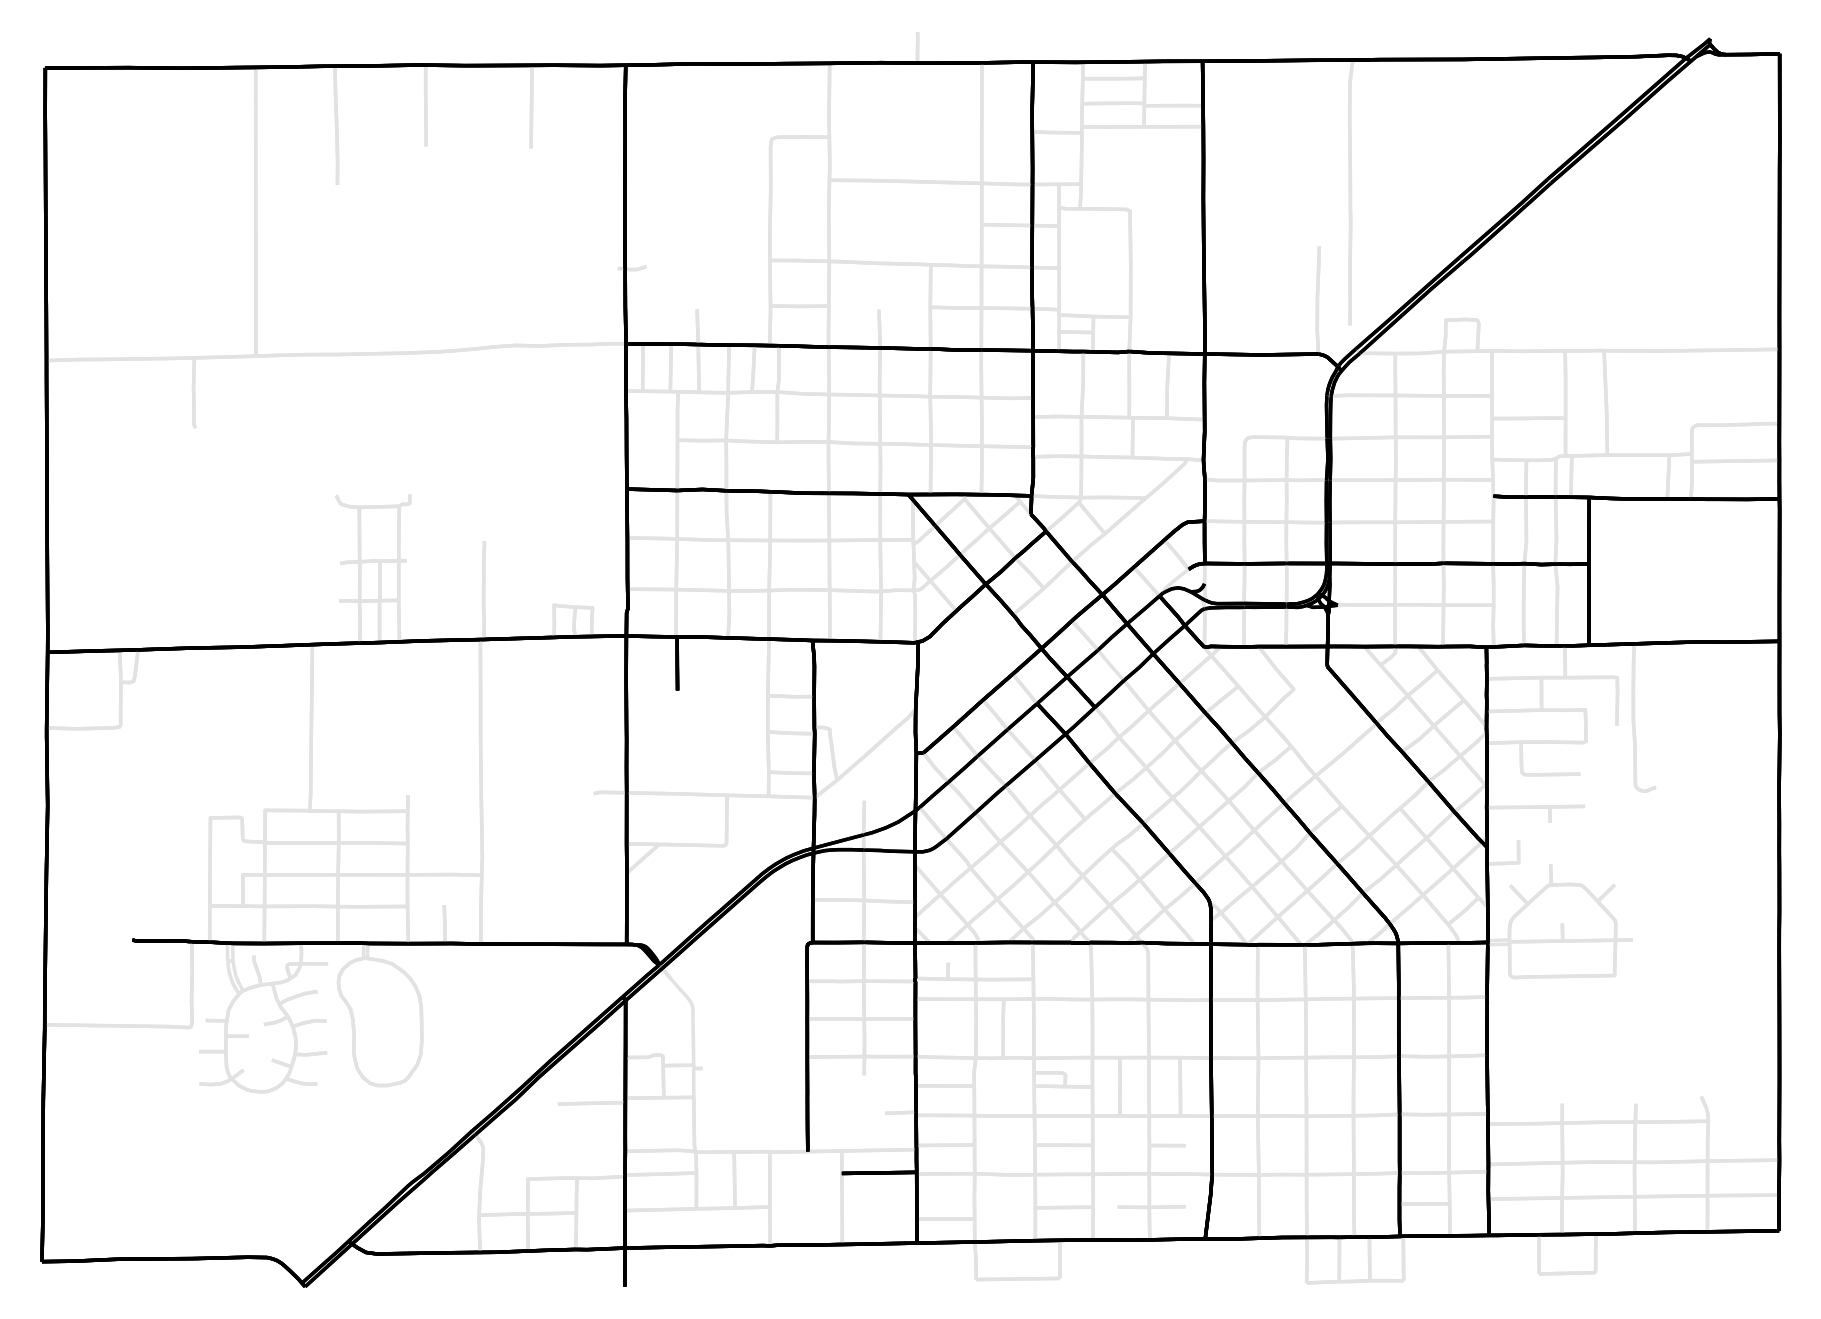

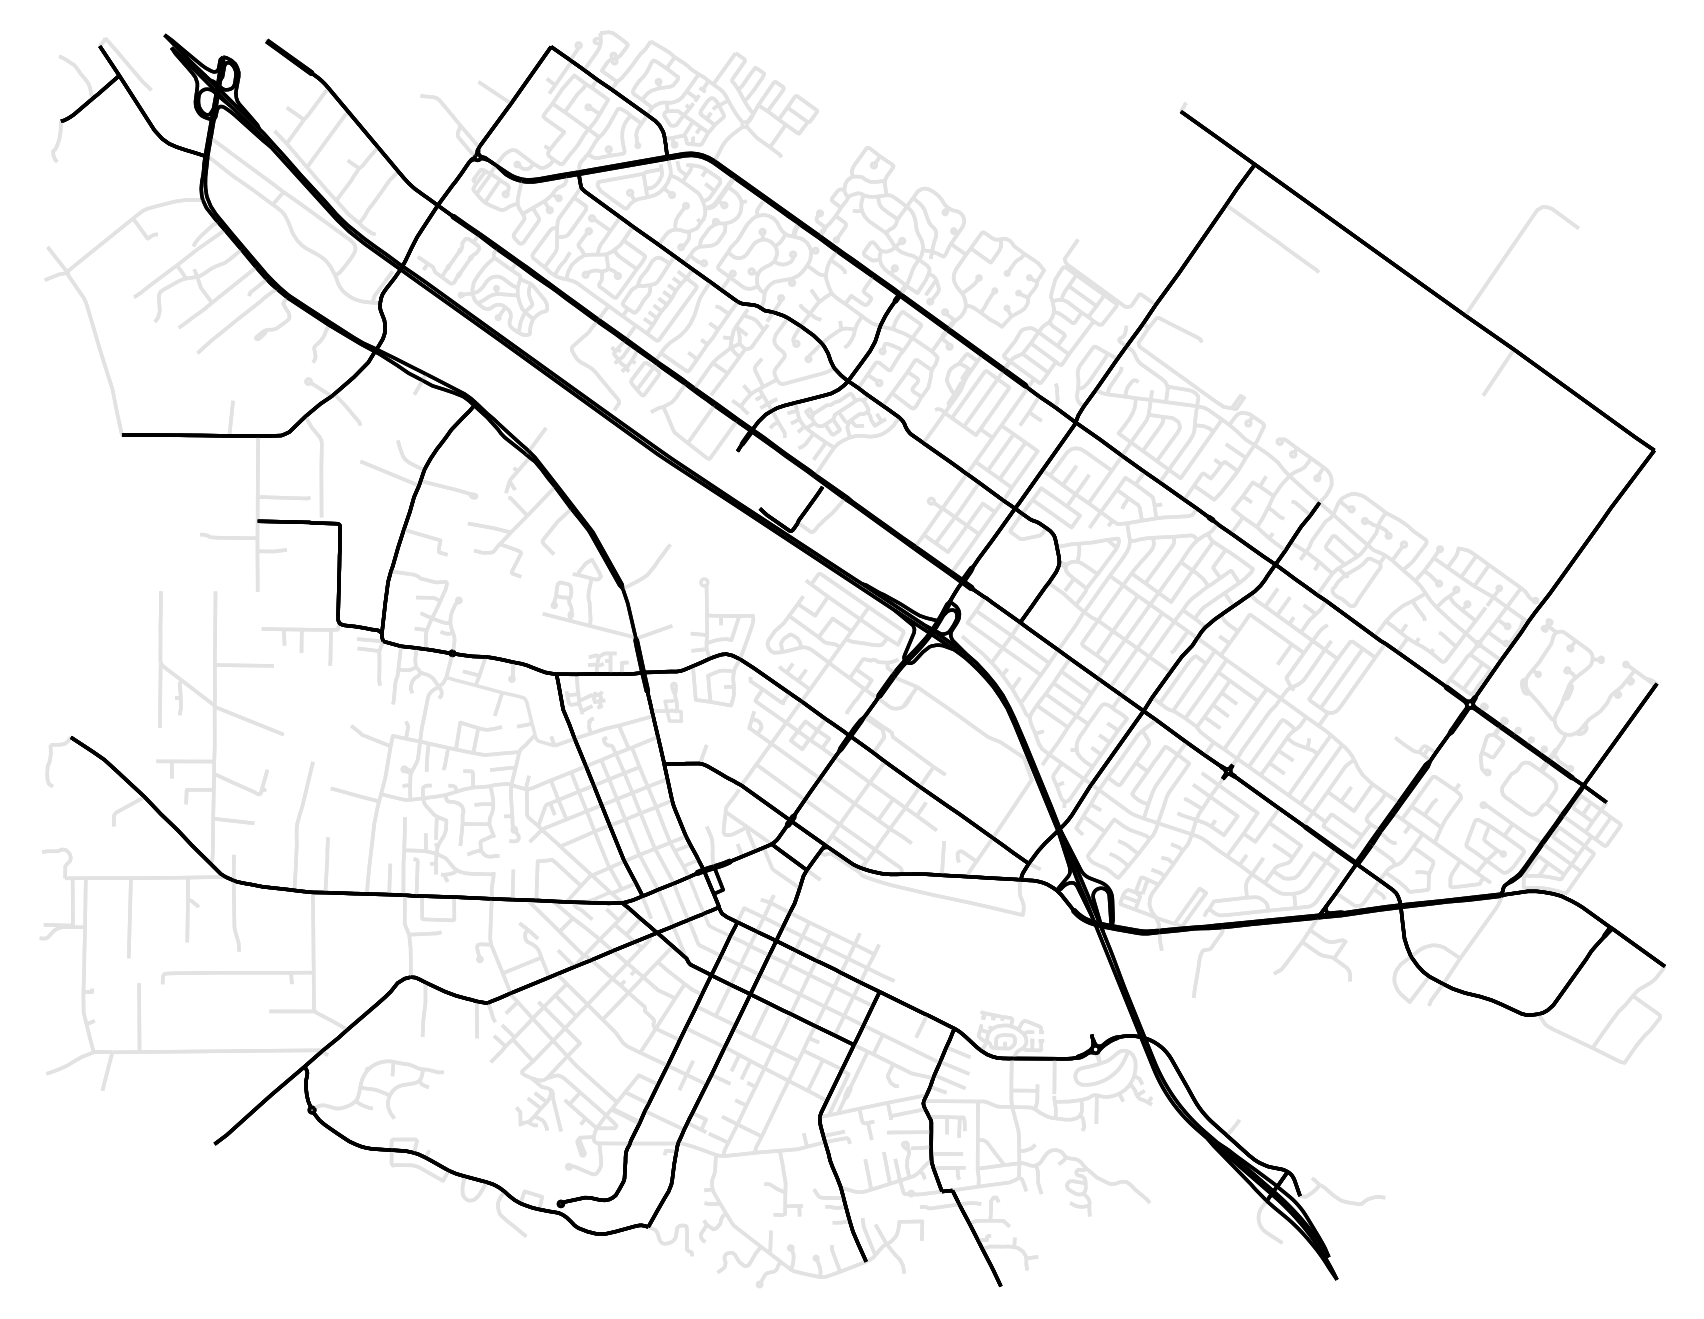

In [28]:
# Plot edge types on the map
Davis_ec = get_edge_colors(Davis_G, Davis_removed_edges)
Portales_ec = get_edge_colors(Portales_G, Portales_removed_edges)
Petaluma_ec = get_edge_colors(Petaluma_G, Petaluma_removed_edges)

bgcolor = 'w'
nc = 'darkgrey'
ns = 50

# Davis, Proposed method
fig, ax = plot_graph(Davis_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3.5, edge_color=Davis_ec, show=False, close=False, bgcolor=bgcolor, removed_nodes=Davis_removed_nodes)

plt.show()
plt.close()

# Portales, Proposed method
fig, ax = plot_graph(Portales_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3.5, edge_color=Portales_ec, show=False, close=False, bgcolor=bgcolor, removed_nodes=Portales_removed_nodes)

plt.show()
plt.close()

# Petaluma, proposed method
fig, ax = plot_graph(Petaluma_G, figsize=(40,24), node_color=nc, node_size=0,
                        edge_linewidth=3.5, edge_color=Petaluma_ec, show=False, close=False, bgcolor=bgcolor, removed_nodes=Petaluma_removed_nodes)

plt.show()
plt.close()

Davis_wo_res_ec = get_edge_colors(Davis_G, Davis_res_roads)
Portales_wo_res_ec = get_edge_colors(Portales_G, Portales_res_roads)
Petaluma_wo_res_ec = get_edge_colors(Petaluma_G, Petaluma_res_roads)

# Davis, w/o res roads
fig, ax = plot_graph(Davis_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3.5, edge_color=Davis_wo_res_ec, show=False, close=False, bgcolor=bgcolor, removed_nodes=Davis_res_removed_nodes)

plt.show()
plt.close()

# Portales, w/o res. roads
fig, ax = plot_graph(Portales_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3.5, edge_color=Portales_wo_res_ec, show=False, close=False, bgcolor=bgcolor, removed_nodes=Portales_res_removed_nodes)

plt.show()
plt.close()

# Petaluma, w/o res. roads
fig, ax = plot_graph(Petaluma_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3.5, edge_color=Petaluma_wo_res_ec, show=False, close=False, bgcolor=bgcolor, removed_nodes=Petaluma_res_removed_nodes)

plt.show()
plt.close()

In [2]:
plt.ioff()

# Columbia
north, west = 34.077988, -81.134183
south, east = 33.909673, -80.908490
# load entire graph
BigCity_G = ox.graph_from_bbox(north, south, east, west, network_type='drive')

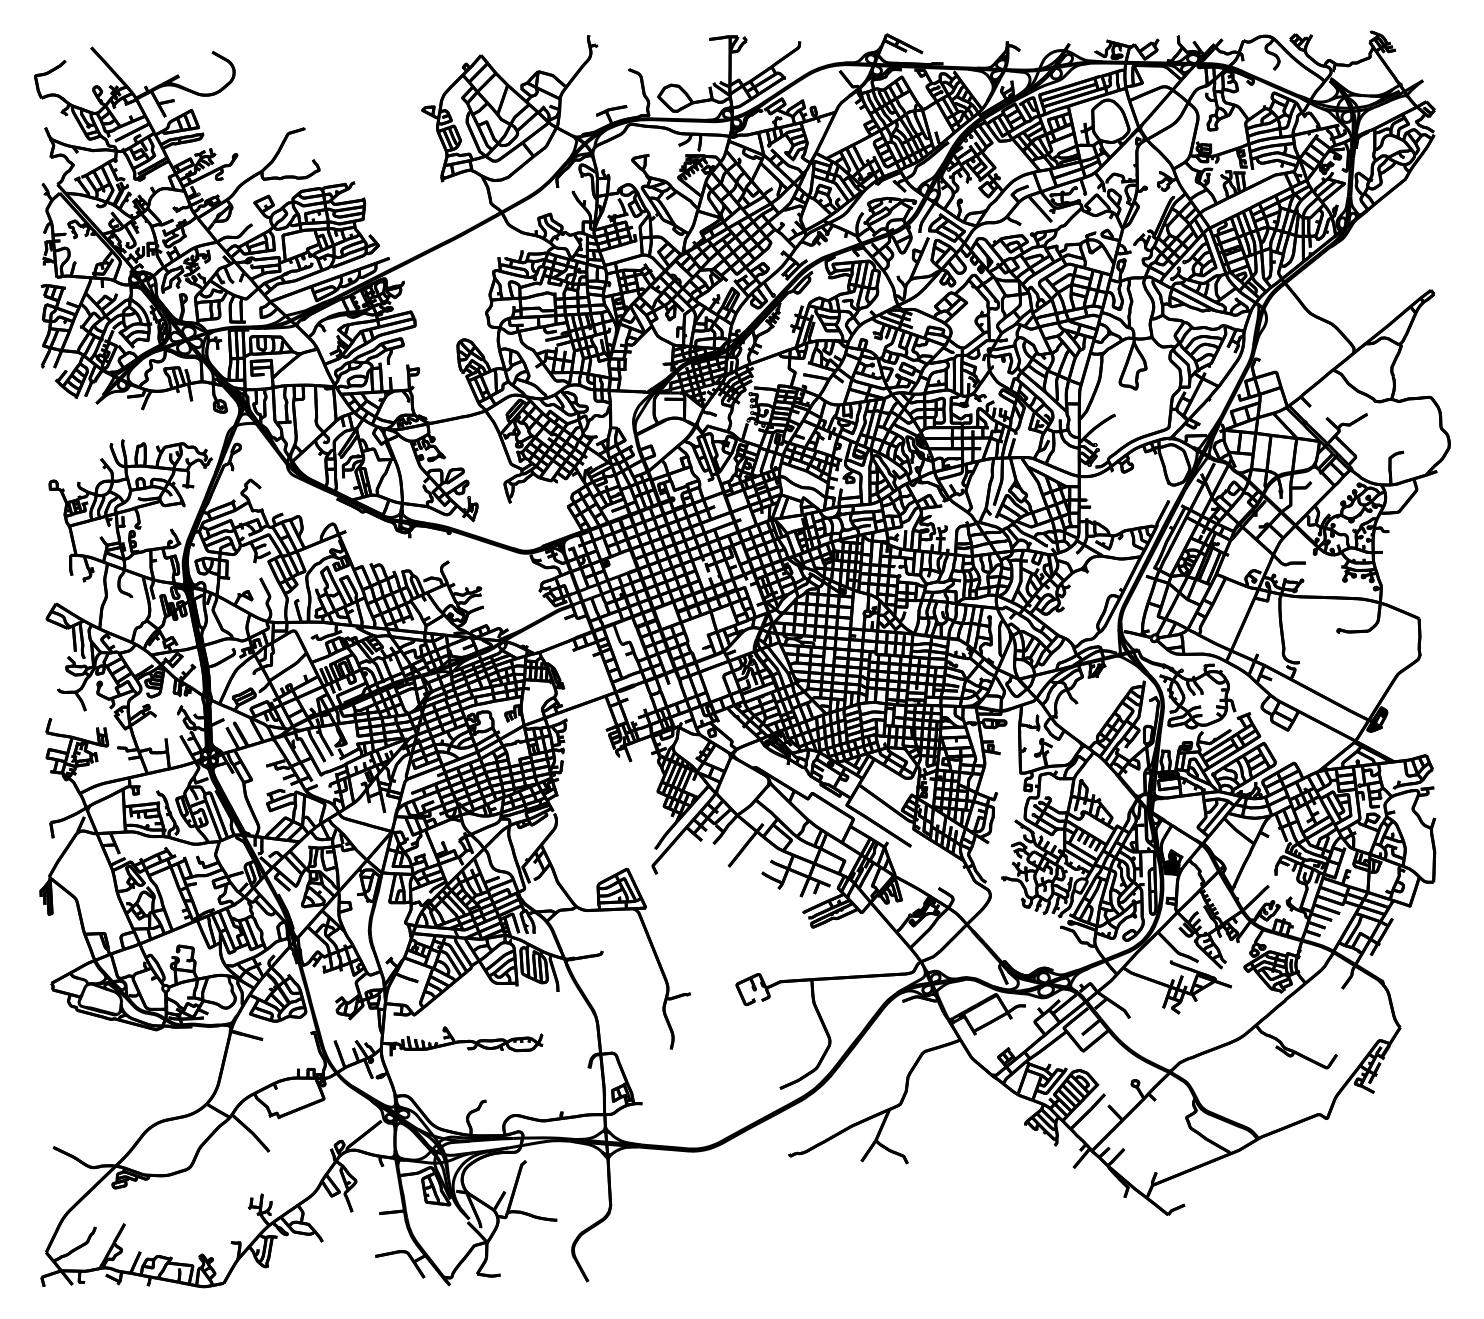

In [14]:
fix, ax = ox.plot_graph(BigCity_G, figsize=(40,24), node_size=0,
                        edge_linewidth=3, edge_color='k', 
                        show=False, close=False, bgcolor='w')

plt.show()
plt.close()

In [19]:
BigCity_G_wo_res, BigCity_res_roads, BigCity_res_removed_nodes = omit_res_roads(BigCity_G, 'Columbia')

Columbia road network w/o residential roads
 - Number of nodes: 3433
 - Number of edges: 6851


In [8]:
print('Working on city of Columbia')
BigCity_simple_G, BigCity_removed_edges, BigCity_removed_nodes, BigCity_removed_cat = simplify(BigCity_G)

Working on city of Columbia
Initial stat (nodes, edges): (11113, 29781)
Stat at iteration 1 (nodes, edges): (6238, 17418)
Stat at iteration 2 (nodes, edges): (5633, 15811)
Stat at iteration 3 (nodes, edges): (5510, 15436)
Stat at iteration 4 (nodes, edges): (5477, 15335)
Stat at iteration 5 (nodes, edges): (5465, 15300)
Stat at iteration 6 (nodes, edges): (5461, 15287)
Stat at iteration 7 (nodes, edges): (5457, 15275)
Graph converged at iteration 7


In [11]:
temp = []
for edge_list in BigCity_removed_edges:
    temp += edge_list
BigCity_removed_edges = temp

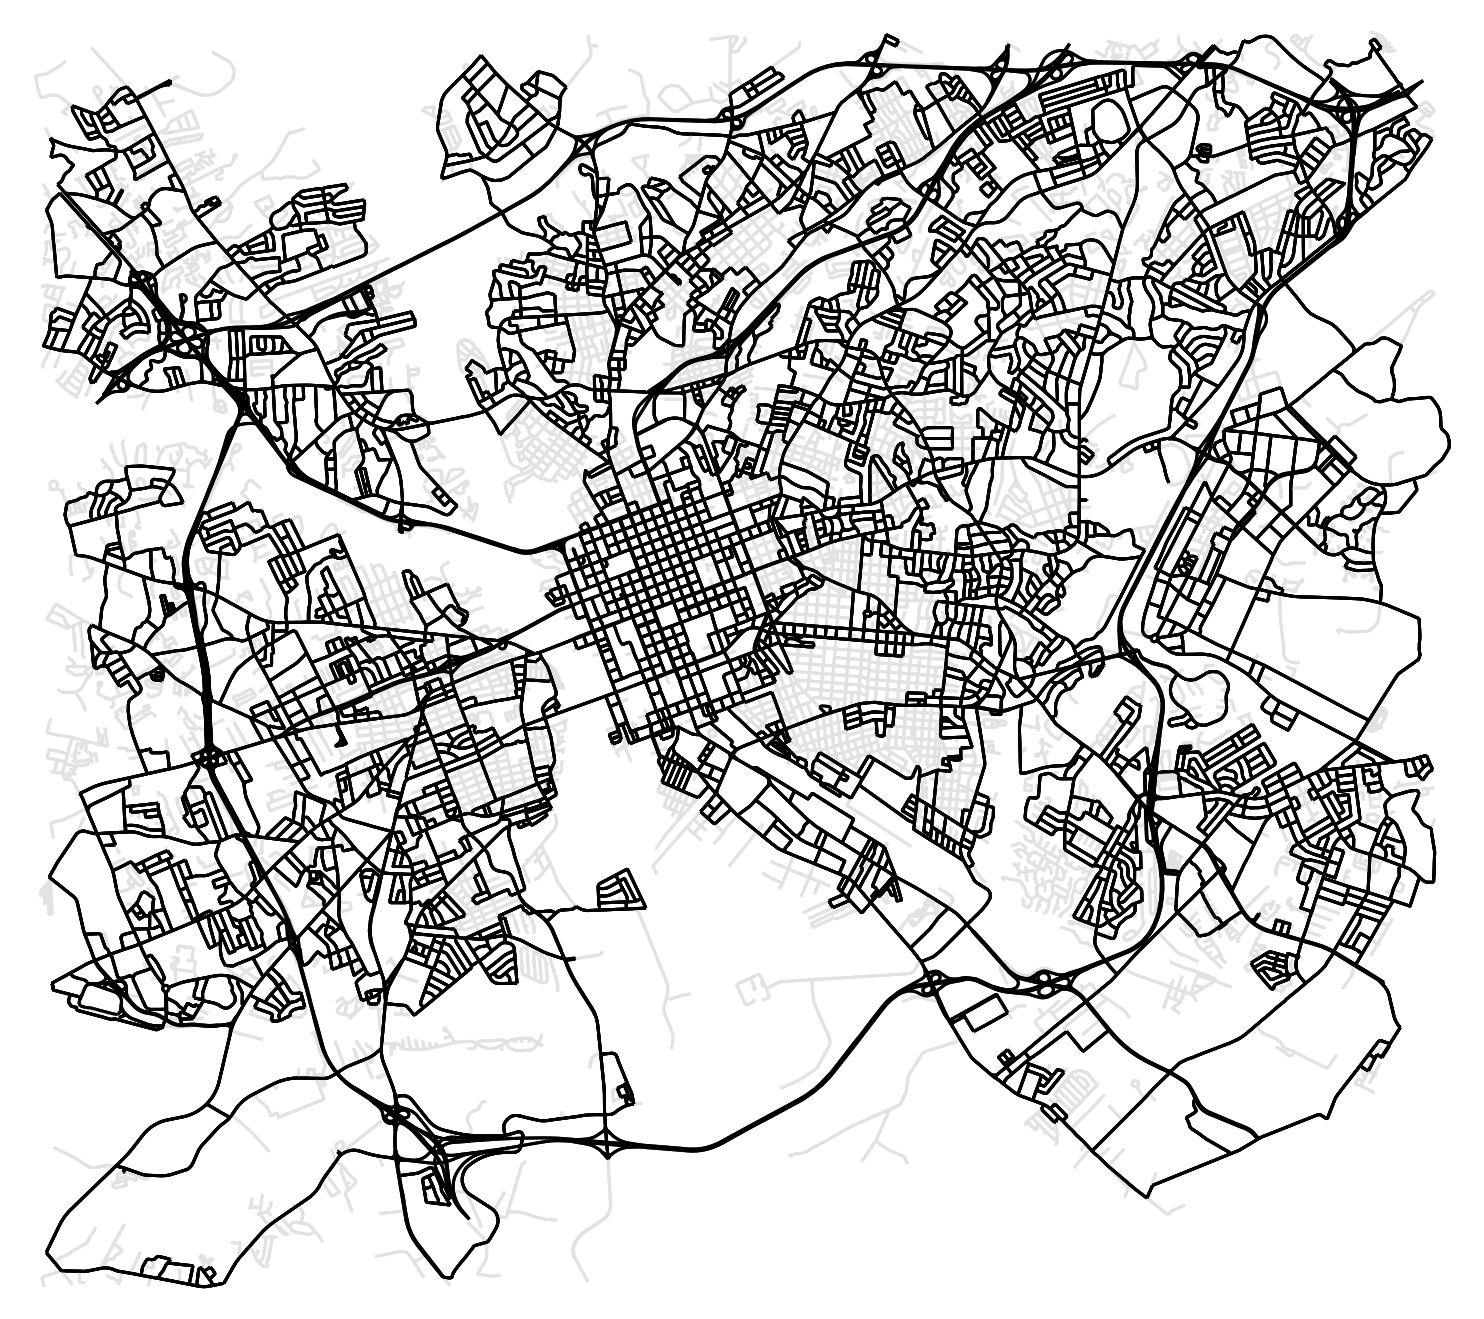

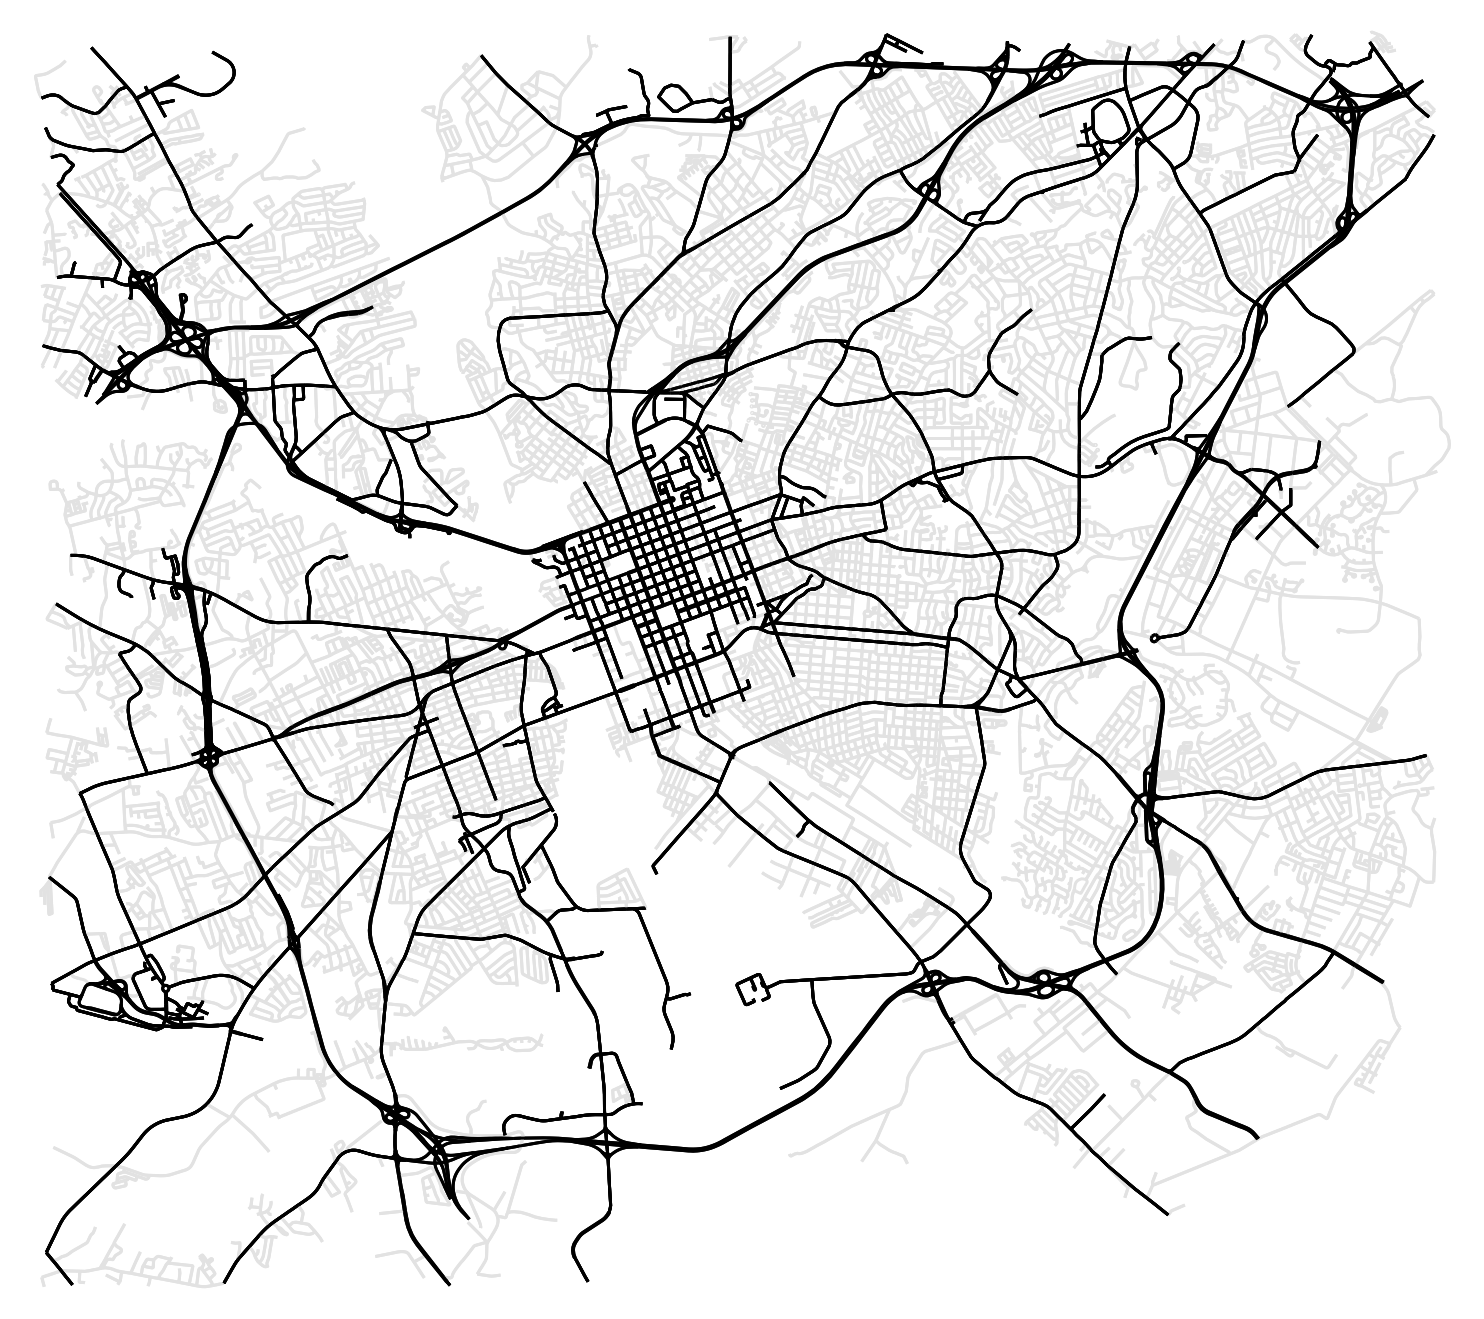

In [20]:
# Plot edge types on the map
BigCity_ec = get_edge_colors(BigCity_G, BigCity_removed_edges)

bgcolor = 'w'
nc = 'darkgrey'
ns = 50

# Columbia, Proposed method
fig, ax = plot_graph(BigCity_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3, edge_color=BigCity_ec, show=False, 
                     close=False, bgcolor=bgcolor, removed_nodes=BigCity_removed_nodes)

plt.show()
plt.close()

BigCity_wo_res_ec = get_edge_colors(BigCity_G, BigCity_res_roads)

# Davis, w/o res roads
fig, ax = plot_graph(BigCity_G, figsize=(40,24), node_color=nc, node_size=ns,
                        edge_linewidth=3, edge_color=BigCity_wo_res_ec, show=False, 
                     close=False, bgcolor=bgcolor, removed_nodes=BigCity_res_removed_nodes)

plt.show()
plt.close()